# Анализ убытков приложения

Необходимо выполнить исследование в качестве маркетингового аналитика развлекательного приложения Procrastinate Pro+.<br>
Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Наша задача — разобраться в причинах и помочь компании выйти в плюс.

Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
- лог сервера с данными об их посещениях;
- выгрузка их покупок за этот период;
- рекламные расходы.

Нам предстоит изучить:
- откуда приходят пользователи и какими устройствами они пользуются;
- сколько стоит привлечение пользователей из различных рекламных каналов;
- сколько денег приносит каждый клиент;
- когда расходы на привлечение клиента окупаются;
- какие факторы мешают привлечению клиентов.

В нашем распоряжении три датасета. Файл `visits_info_short.csv` хранит лог сервера с информацией о посещениях сайта, `orders_info_short.csv` — информацию о заказах, а `costs_info_short.csv` — информацию о расходах на рекламу.

## Выгрузка и предобработка данных для анализа

### Выгрузка данных

Загрузим данные о визитах, заказах и рекламных расходах из CSV-файлов в переменные.

In [1]:
# Импортирование всех необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Устанавливаем стиль оформления
sns.set(style="whitegrid")

pd.set_option('display.max_rows', None)  # Показывать все строки
pd.set_option('display.max_columns', None)  # Показывать все столбцы
pd.set_option('display.width', None)  # Убираем ограничение на ширину
pd.set_option('display.expand_frame_repr', False)  # Выводить датафрейм как есть, не разделяя строки на блоки

In [2]:
# Загрузка данных о визитах
visits = pd.read_csv('visits_info_short.csv')
visits.head()

User Id         Region   Device  Channel        Session Start          Session End
0  981449118918  United States   iPhone  organic  2019-05-01 02:36:01  2019-05-01 02:45:01
1  278965908054  United States   iPhone  organic  2019-05-01 04:46:31  2019-05-01 04:47:35
2  590706206550  United States      Mac  organic  2019-05-01 14:09:25  2019-05-01 15:32:08
3  326433527971  United States  Android   TipTop  2019-05-01 00:29:59  2019-05-01 00:54:25
4  349773784594  United States      Mac  organic  2019-05-01 03:33:35  2019-05-01 03:57:40

In [3]:
# Загрузка данных о заказах
orders = pd.read_csv('orders_info_short.csv')
orders.head()

User Id             Event Dt  Revenue
0  188246423999  2019-05-01 23:09:52     4.99
1  174361394180  2019-05-01 12:24:04     4.99
2  529610067795  2019-05-01 11:34:04     4.99
3  319939546352  2019-05-01 15:34:40     4.99
4  366000285810  2019-05-01 13:59:51     4.99

In [4]:
# Загрузка данных о рекламных расходах
costs = pd.read_csv('costs_info_short.csv')
costs.head()

dt   Channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8
3  2019-05-04  FaceBoom  136.4
4  2019-05-05  FaceBoom  122.1

Теперь изучим данные детальнее.

In [5]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


- `User Id` — уникальный идентификатор пользователя, тип данных: int64.
- `Region` — страна пользователя, тип данных: object (строка).
- `Device` — тип устройства пользователя, тип данных: object (строка).
- `Channel` — идентификатор источника перехода, тип данных: object (строка).
- `Session Start` — дата и время начала сессии, тип данных: object (строка, но должно быть преобразовано в формат datetime).
- `Session End` — дата и время окончания сессии, тип данных: object (строка, но должно быть преобразовано в формат datetime).

In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


- `User Id` — уникальный идентификатор пользователя, тип данных: int64.
- `Event Dt` — дата и время покупки, тип данных: object (строка, но должно быть преобразовано в формат datetime).
- `Revenue` — сумма заказа, тип данных: float64.

In [7]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


- `dt` — дата проведения рекламной кампании, тип данных: object (строка, но должно быть преобразовано в формат datetime).
- `Channel` — идентификатор рекламного источника, тип данных: object (строка).
- `costs` — расходы на эту кампанию, тип данных: float64.

Итак, мы выгрузили и детально рассмотрели данные. <br>
Заметим, что во всех трех датасетах отсутствуют пропуски.

### Предобработка данных

#### Проверка корректности типов данных

Выполним предобработку данных. Начнём с изменения типов данных в столбцах с датой и временем.

In [8]:
# Преобразование столбцов с датами в формат datetime
visits['Session Start'] = pd.to_datetime(visits['Session Start'])
visits['Session End'] = pd.to_datetime(visits['Session End'])
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   User Id        309901 non-null  int64         
 1   Region         309901 non-null  object        
 2   Device         309901 non-null  object        
 3   Channel        309901 non-null  object        
 4   Session Start  309901 non-null  datetime64[ns]
 5   Session End    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


In [9]:
orders['Event Dt'] = pd.to_datetime(orders['Event Dt'])
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   User Id   40212 non-null  int64         
 1   Event Dt  40212 non-null  datetime64[ns]
 2   Revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


In [10]:
costs['dt'] = pd.to_datetime(costs['dt']).dt.date # здесь тип данных останется object
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


Теперь типы данных во всех столбцах корректны.

#### Проверка пропусков

Как мы уже заметили, пропусков в данных нет, но давайте в этом убедимся с помощью явного подсчета.

In [11]:
# Проверка на пропущенные значения
visits.isnull().sum()

User Id          0
Region           0
Device           0
Channel          0
Session Start    0
Session End      0
dtype: int64

In [12]:
# Проверка на пропущенные значения
orders.isnull().sum()

User Id     0
Event Dt    0
Revenue     0
dtype: int64

In [13]:
# Проверка на пропущенные значения
costs.isnull().sum()

dt         0
Channel    0
costs      0
dtype: int64

Отлично, пропусков действительно нет.

#### Поиск дубликатов

Теперь изучим, есть ли в данных дубликаты.

In [14]:
# Проверка на дубликаты в каждом датасете
visits_duplicates = visits.duplicated().sum()
orders_duplicates = orders.duplicated().sum()
costs_duplicates = costs.duplicated().sum()

In [15]:
# Вывод результатов
print(f'Дубликаты в visits: {visits_duplicates}')
print(f'Дубликаты в orders: {orders_duplicates}')
print(f'Дубликаты в costs: {costs_duplicates}')

Дубликаты в visits: 0
Дубликаты в orders: 0
Дубликаты в costs: 0


Явных дублей не обнаружено. Неявные дубли можно проверить в первом датафрейме. Проверим, есть ли сессии с одинаковыми `Session Start` и `Session End` для одного и того же пользователя.

In [16]:
duplicate_sessions = visits[visits.duplicated(subset=['User Id', 'Session Start', 'Session End'], keep=False)]
duplicate_sessions

Empty DataFrame
Columns: [User Id, Region, Device, Channel, Session Start, Session End]
Index: []

Отлично. Для остальных случаев подходит проверка по явным дублям. Итак, проверка на дубли пройдена.

Таким образом, мы выгрузили и изучили данные, а так же выполнили предобработку. Теперь можно приступать к анализу.

## Функции для расчёта и анализа LTV, ROI, Retention Rate и конверсии

Зададим функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

In [17]:
# функция для создания пользовательских профилей

def get_profiles(visits, orders, costs):
    # Находим параметры первых посещений
    profiles = (
        visits.sort_values(by=['User Id', 'Session Start'])
        .groupby('User Id')
        .agg(
            {
                'Session Start': 'first',
                'Channel': 'first',
                'Device': 'first',
                'Region': 'first',
            }
        )
        .rename(columns={'Session Start': 'first_ts'})
        .reset_index()
    )

    # Определяем дату первого посещения и первый месяц
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].values.astype('datetime64[M]')

    # Добавляем признак платящих пользователей
    profiles['payer'] = profiles['User Id'].isin(orders['User Id'].unique())

    # Считаем количество уникальных пользователей по дате и каналу
    new_users = (
        profiles.groupby(['dt', 'Channel'])
        .agg({'User Id': 'nunique'})
        .rename(columns={'User Id': 'unique_users'})
        .reset_index()
    )

    # Объединяем траты на рекламу и число привлечённых пользователей
    costs = costs.merge(new_users, left_on=['dt', 'Channel'], right_on=['dt', 'Channel'], how='left')

    # Делим рекламные расходы на число привлечённых пользователей
    costs['acquisition_cost'] = costs['costs'] / costs['unique_users']

    # Добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        costs[['dt', 'Channel', 'acquisition_cost']],
        on=['dt', 'Channel'],
        how='left'
    )

    # Стоимость привлечения для органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [18]:
# функция для расчёта удержания

def get_retention(profiles, sessions, observation_date, horizon_days, dimensions=[], ignore_horizon=False):
    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - pd.Timedelta(days=horizon_days - 1)
    
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(sessions[['User Id', 'Session Start']], on='User Id', how='left')
    result_raw['lifetime'] = (result_raw['Session Start'] - result_raw['first_ts']).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(index=dims, columns='lifetime', values='User Id', aggfunc='nunique')
        cohort_sizes = df.groupby(dims).agg({'User Id': 'nunique'}).rename(columns={'User Id': 'cohort_size'})
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [19]:
# функция для расчёта конверсии

def get_conversion(profiles, purchases, observation_date, horizon_days, dimensions=[], ignore_horizon=False):
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - pd.Timedelta(days=horizon_days - 1)
    
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = purchases.sort_values(by=['User Id', 'Event Dt']).groupby('User Id').agg({'Event Dt': 'first'}).reset_index()

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(first_purchases[['User Id', 'Event Dt']], on='User Id', how='left')

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (result_raw['Event Dt'] - result_raw['first_ts']).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(index=dims, columns='lifetime', values='User Id', aggfunc='nunique').fillna(0).cumsum(axis=1)
        cohort_sizes = df.groupby(dims).agg({'User Id': 'nunique'}).rename(columns={'User Id': 'cohort_size'})
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [20]:
# функция для расчёта LTV и ROI

def get_ltv(profiles, purchases, observation_date, horizon_days, dimensions=[], ignore_horizon=False):
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - pd.Timedelta(days=horizon_days - 1)
    
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    result_raw = result_raw.merge(purchases[['User Id', 'Event Dt', 'Revenue']], on='User Id', how='left')
    result_raw['lifetime'] = (result_raw['Event Dt'] - result_raw['first_ts']).dt.days

    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(index=dims, columns='lifetime', values='Revenue', aggfunc='sum').fillna(0).cumsum(axis=1)
        cohort_sizes = df.groupby(dims).agg({'User Id': 'nunique'}).rename(columns={'User Id': 'cohort_size'})
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes

        cac = df[['User Id', 'acquisition_cost'] + dims].drop_duplicates()
        cac = cac.groupby(dims).agg({'acquisition_cost': 'mean'}).rename(columns={'acquisition_cost': 'CAC'})

        roi = result.div(cac['CAC'], axis=0)
        roi = roi[~roi['cohort_size'].isin([np.inf])]
        roi['cohort_size'] = cohort_sizes
        roi['CAC'] = cac['CAC']
        roi = roi[['cohort_size', 'CAC'] + list(range(horizon_days))]

        return result, roi

    result_grouped, roi_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    if 'cohort' in dimensions:
        dimensions = []

    result_in_time, roi_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)

    return result_raw, result_grouped, result_in_time, roi_grouped, roi_in_time

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

In [21]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [22]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):
    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0], errors='ignore')
    retention_history = retention_history.drop(columns=['cohort_size'], errors='ignore')[[horizon - 1]]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(grid=True, ax=ax2)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    columns = [name for name in retention_history.index.names if name not in ['dt', 'payer']]
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(f'Динамика удержания платящих пользователей на {horizon}-й день')

    # в четвёртой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(f'Динамика удержания неплатящих пользователей на {horizon}-й день')

    plt.tight_layout()
    plt.show()

In [23]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):
    plt.figure(figsize=(15, 5))

    # Исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'], errors='ignore')
    conversion_history = conversion_history.drop(columns=['cohort_size'], errors='ignore')[[horizon - 1]]

    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend(title='Cohort')
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [24]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):
    plt.figure(figsize=(20, 15))

    # Исключаем размеры когорт и несущественные столбцы
    ltv = ltv.drop(columns=['cohort_size'], errors='ignore')
    ltv_history = ltv_history.drop(columns=['cohort_size'], errors='ignore')[[horizon - 1]]
    
    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['CAC']]
    
    roi = roi.drop(columns=['cohort_size', 'CAC'], errors='ignore')
    roi_history = roi_history.drop(columns=['cohort_size', 'CAC'], errors='ignore')[[horizon - 1]]

    # Построение LTV
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # Третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='CAC', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # Построение ROI
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

Таким образом, у нас есть необходимый набор функций, который поможет нам в дальнейшем анализе.

## Исследовательский анализ данных

### Профили пользователей

Составим профили пользователей и определим минимальную и максимальную даты привлечения пользователей.

In [25]:
# Создание профилей пользователей без событий
profiles = get_profiles(visits, orders, costs)

# Выводим первые строки профилей для проверки
profiles.head()

User Id            first_ts     Channel  Device         Region          dt      month  payer  acquisition_cost
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States  2019-05-07 2019-05-01   True          1.088172
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States  2019-07-09 2019-07-01  False          1.107237
2   6085896 2019-10-01 09:58:33     organic  iPhone         France  2019-10-01 2019-10-01  False          0.000000
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany  2019-08-22 2019-08-01  False          0.988235
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States  2019-10-02 2019-10-01  False          0.230769

In [26]:
# Минимальная дата привлечения пользователей
min_date = profiles['dt'].min()

# Максимальная дата привлечения пользователей
max_date = profiles['dt'].max()

print(f'Минимальная дата привлечения пользователей: {min_date}')
print(f'Максимальная дата привлечения пользователей: {max_date}')

Минимальная дата привлечения пользователей: 2019-05-01
Максимальная дата привлечения пользователей: 2019-10-27


Мы сформировали профили пользователей, а так же узнали минимальную и максимальную дату привлечения пользователей:<br>
2019-05-01 и 2019-10-27 соответственно. Даты совпадают с данными из задания.  

### Пользователи по странам

Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей.<br> Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.

In [27]:
# Подсчет количества пользователей из каждой страны
users_by_country = profiles.groupby('Region')['User Id'].nunique().reset_index()
users_by_country = users_by_country.rename(columns={'User Id': 'total_users'})

# Подсчет количества платящих пользователей из каждой страны
paying_users_by_country = profiles[profiles['payer']].groupby('Region')['User Id'].nunique().reset_index()
paying_users_by_country = paying_users_by_country.rename(columns={'User Id': 'paying_users'})

# Объединение данных и расчет доли платящих пользователей
country_analysis = users_by_country.merge(paying_users_by_country, on='Region', how='left')
country_analysis['paying_users'] = country_analysis['paying_users'].fillna(0)
country_analysis['paying_ratio, %'] = country_analysis['paying_users'] / country_analysis['total_users'] * 100

# Сортировка таблицы по количеству пользователей и отображение результатов
country_analysis = country_analysis.sort_values(by='total_users', ascending=False).reset_index(drop=True)

country_analysis

Region  total_users  paying_users  paying_ratio, %
0  United States       100002          6902         6.901862
1             UK        17575           700         3.982930
2         France        17450           663         3.799427
3        Germany        14981           616         4.111875

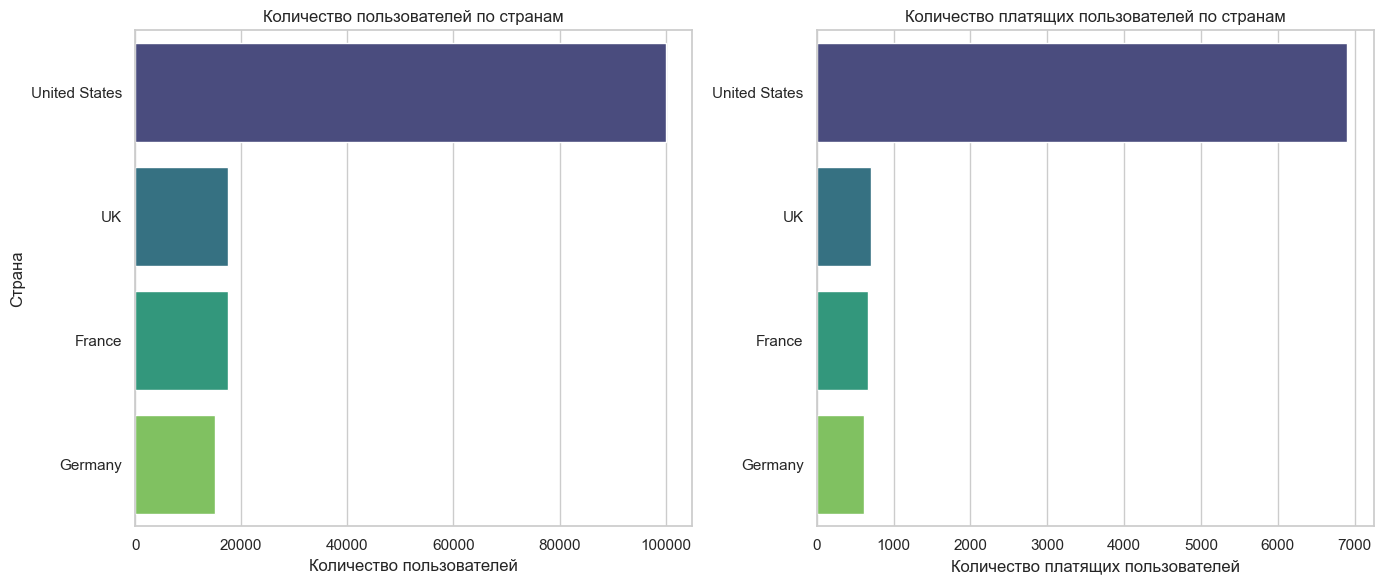

In [28]:
# Построим несколько графиков для визуализации результатов
# Размер графиков
plt.figure(figsize=(14, 6))

# График 1: количество всех пользователей по странам
plt.subplot(1, 2, 1)
sns.barplot(x='total_users', y='Region', data=country_analysis, palette="viridis")
plt.title('Количество пользователей по странам')
plt.xlabel('Количество пользователей')
plt.ylabel('Страна')

# График 2: количество платящих пользователей по странам
plt.subplot(1, 2, 2)
sns.barplot(x='paying_users', y='Region', data=country_analysis, palette="viridis")
plt.title('Количество платящих пользователей по странам')
plt.xlabel('Количество платящих пользователей')
plt.ylabel('')

# Показать графики
plt.tight_layout()
plt.show()

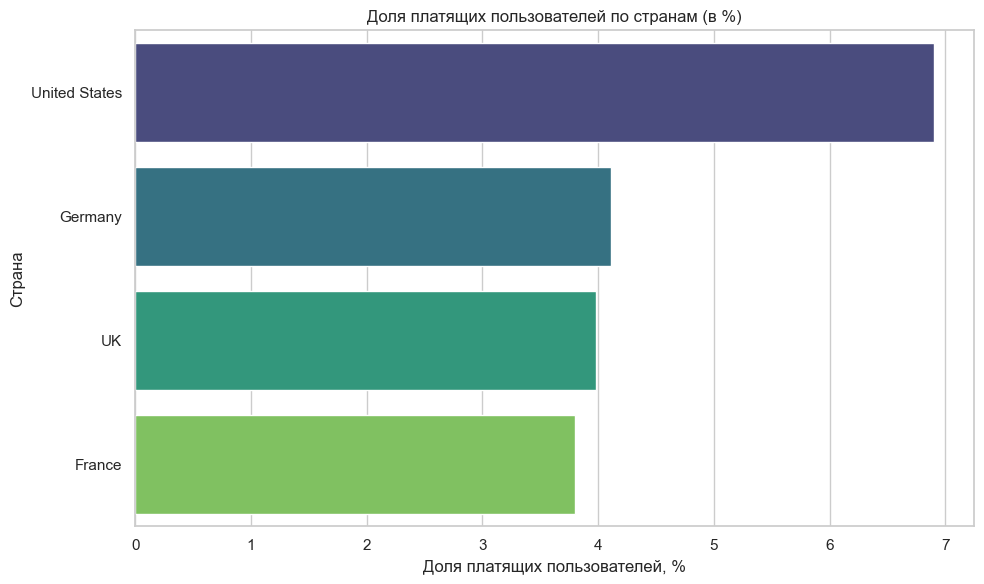

In [29]:
# Сортировка по доле платящих пользователей
country_analysis_sorted = country_analysis.sort_values(by='paying_ratio, %', ascending=False)

# Построение графика для стран
plt.figure(figsize=(10, 6))
sns.barplot(x='paying_ratio, %', y='Region', data=country_analysis_sorted, palette="viridis")
plt.title('Доля платящих пользователей по странам (в %)')
plt.xlabel('Доля платящих пользователей, %')
plt.ylabel('Страна')

# Показать график
plt.tight_layout()
plt.show()

Соединенные Штаты лидируют по количеству пользователей (100,002) и платящих пользователей (6,902), что говорит о высокой популярности приложения в этом регионе. Однако, доля платящих пользователей (6.9%) в США хотя и выше, чем в других странах, незначительно превышает показатели Великобритании (3.98%), Франции (3.8%) и Германии (4.11%) относительно разницы в количестве пользователей. Это говорит о том, что конверсия в платящих пользователей в США сопоставима с другими странами.

### Устройства пользователей

Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи.<br>
Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.

In [30]:
# Подсчет количества пользователей по устройствам
users_by_device = profiles.groupby('Device')['User Id'].nunique().reset_index()
users_by_device = users_by_device.rename(columns={'User Id': 'total_users'})

# Подсчет количества платящих пользователей по устройствам
paying_users_by_device = profiles[profiles['payer']].groupby('Device')['User Id'].nunique().reset_index()
paying_users_by_device = paying_users_by_device.rename(columns={'User Id': 'paying_users'})

# Объединение данных и расчет доли платящих пользователей
device_analysis = users_by_device.merge(paying_users_by_device, on='Device', how='left')
device_analysis['paying_users'] = device_analysis['paying_users'].fillna(0)
device_analysis['paying_ratio, %'] = device_analysis['paying_users'] / device_analysis['total_users'] * 100

# Сортировка таблицы по количеству пользователей и отображение результатов
device_analysis = device_analysis.sort_values(by='total_users', ascending=False).reset_index(drop=True)

device_analysis

Device  total_users  paying_users  paying_ratio, %
0   iPhone        54479          3382         6.207897
1  Android        35032          2050         5.851793
2       PC        30455          1537         5.046790
3      Mac        30042          1912         6.364423

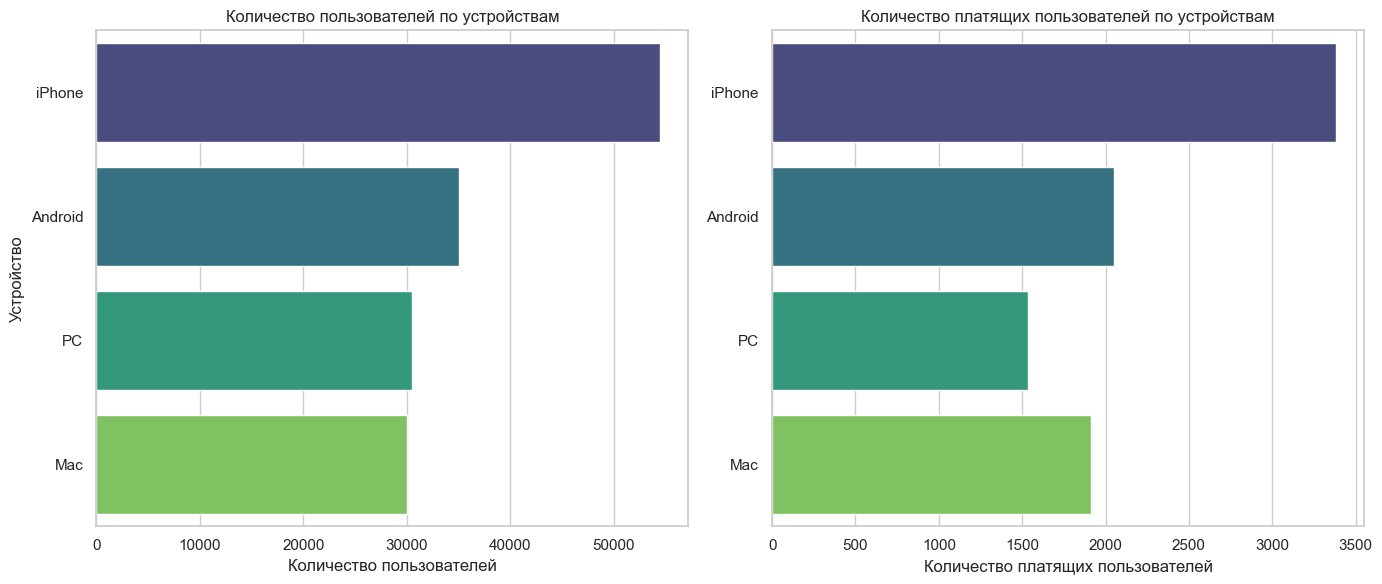

In [31]:
# Аналогично добавим несколько графиков для визуализации результатов
# Размер графиков
plt.figure(figsize=(14, 6))

# График 1: количество всех пользователей по устройствам
plt.subplot(1, 2, 1)
sns.barplot(x='total_users', y='Device', data=device_analysis, palette="viridis")
plt.title('Количество пользователей по устройствам')
plt.xlabel('Количество пользователей')
plt.ylabel('Устройство')

# График 2: количество платящих пользователей по устройствам
plt.subplot(1, 2, 2)
sns.barplot(x='paying_users', y='Device', data=device_analysis, palette="viridis")
plt.title('Количество платящих пользователей по устройствам')
plt.xlabel('Количество платящих пользователей')
plt.ylabel('')

# Показать графики
plt.tight_layout()
plt.show()

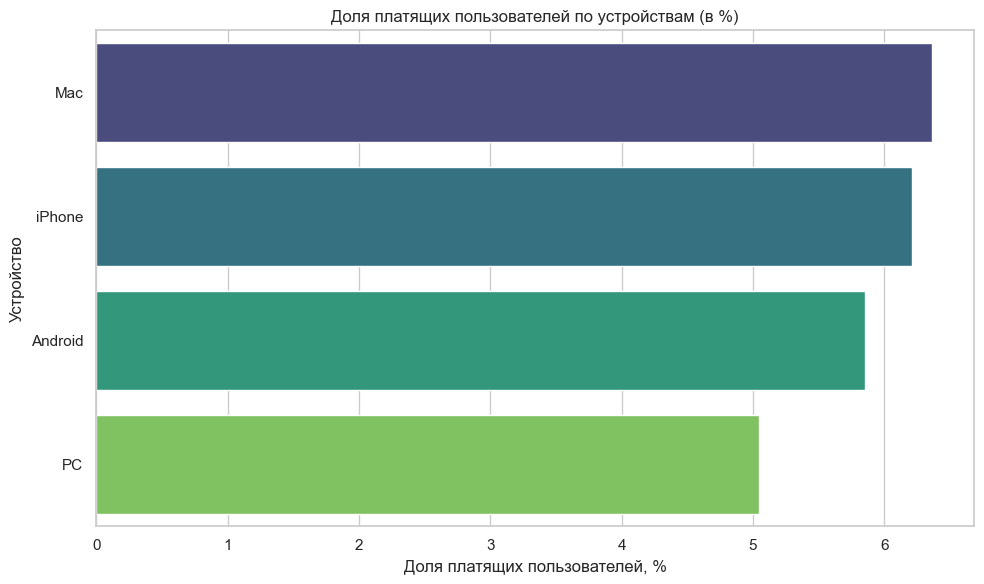

In [32]:
# Сортировка по доле платящих пользователей
device_analysis_sorted = device_analysis.sort_values(by='paying_ratio, %', ascending=False)

# Построение графика для устройств
plt.figure(figsize=(10, 6))
sns.barplot(x='paying_ratio, %', y='Device', data=device_analysis_sorted, palette="viridis")
plt.title('Доля платящих пользователей по устройствам (в %)')
plt.xlabel('Доля платящих пользователей, %')
plt.ylabel('Устройство')

# Показать график
plt.tight_layout()
plt.show()

iPhone лидирует по количеству пользователей, а так же занимает 2 место по доле платящих (6.2%). Mac, хоть и имеет наименьшее количество пользователей, у него наибольшая доля платящих пользователей (6.4%). На третьем месте Android (5.8%), а на последнем - PC (5%).

### Рекламные источники

Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей.<br>
Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [33]:
# Подсчет количества пользователей по каналам
users_by_channel = profiles.groupby('Channel')['User Id'].nunique().reset_index()
users_by_channel = users_by_channel.rename(columns={'User Id': 'total_users'})

# Подсчет количества платящих пользователей по каналам
paying_users_by_channel = profiles[profiles['payer']].groupby('Channel')['User Id'].nunique().reset_index()
paying_users_by_channel = paying_users_by_channel.rename(columns={'User Id': 'paying_users'})

# Объединение данных и расчет доли платящих пользователей
channel_analysis = users_by_channel.merge(paying_users_by_channel, on='Channel', how='left')
channel_analysis['paying_users'] = channel_analysis['paying_users'].fillna(0)
channel_analysis['paying_ratio, %'] = channel_analysis['paying_users'] / channel_analysis['total_users'] * 100

# Сортировка таблицы по количеству пользователей и отображение результатов
channel_analysis = channel_analysis.sort_values(by='total_users', ascending=False).reset_index(drop=True)

channel_analysis

Channel  total_users  paying_users  paying_ratio, %
0              organic        56439          1160         2.055316
1             FaceBoom        29144          3557        12.204914
2               TipTop        19561          1878         9.600736
3   OppleCreativeMedia         8605           233         2.707728
4              LeapBob         8553           262         3.063253
5       WahooNetBanner         8553           453         5.296387
6       RocketSuperAds         4448           352         7.913669
7         MediaTornado         4364           156         3.574702
8              YRabbit         4312           165         3.826531
9           AdNonSense         3880           440        11.340206
10      lambdaMediaAds         2149           225        10.469986

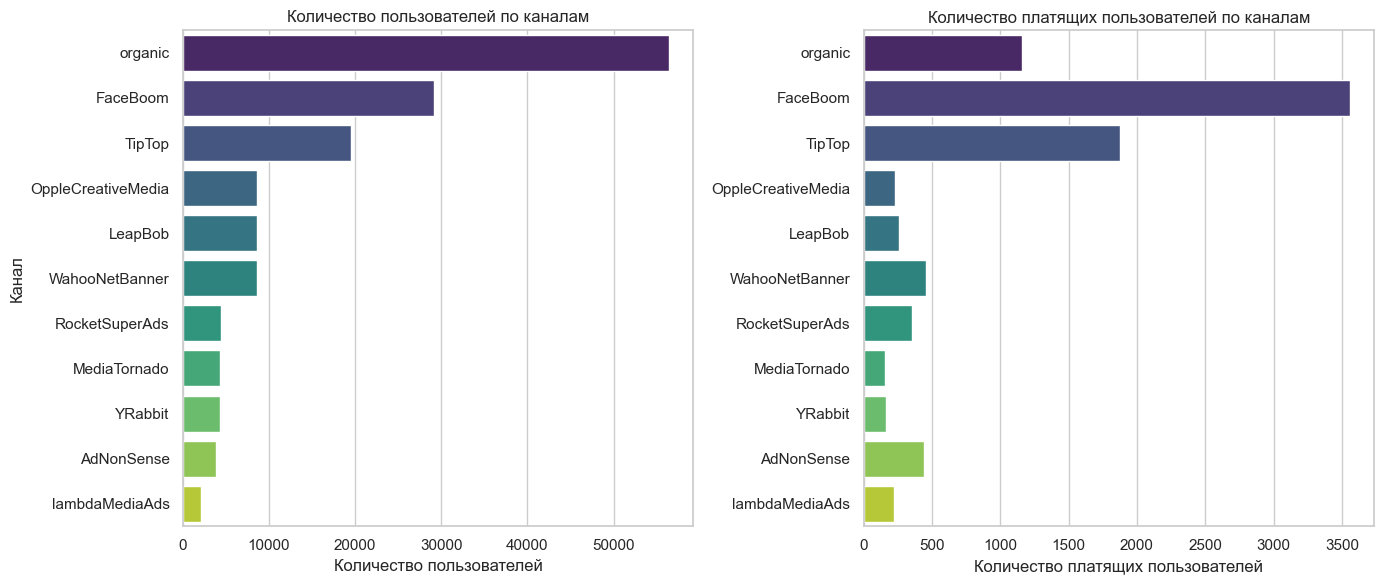

In [34]:
# Добавим несколько графиков графиков
# Размер графиков
plt.figure(figsize=(14, 6))

# График 1: количество всех пользователей по каналам
plt.subplot(1, 2, 1)
sns.barplot(x='total_users', y='Channel', data=channel_analysis, palette="viridis")
plt.title('Количество пользователей по каналам')
plt.xlabel('Количество пользователей')
plt.ylabel('Канал')

# График 2: количество платящих пользователей по каналам
plt.subplot(1, 2, 2)
sns.barplot(x='paying_users', y='Channel', data=channel_analysis, palette="viridis")
plt.title('Количество платящих пользователей по каналам')
plt.xlabel('Количество платящих пользователей')
plt.ylabel('')

# Показать графики
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Канал')

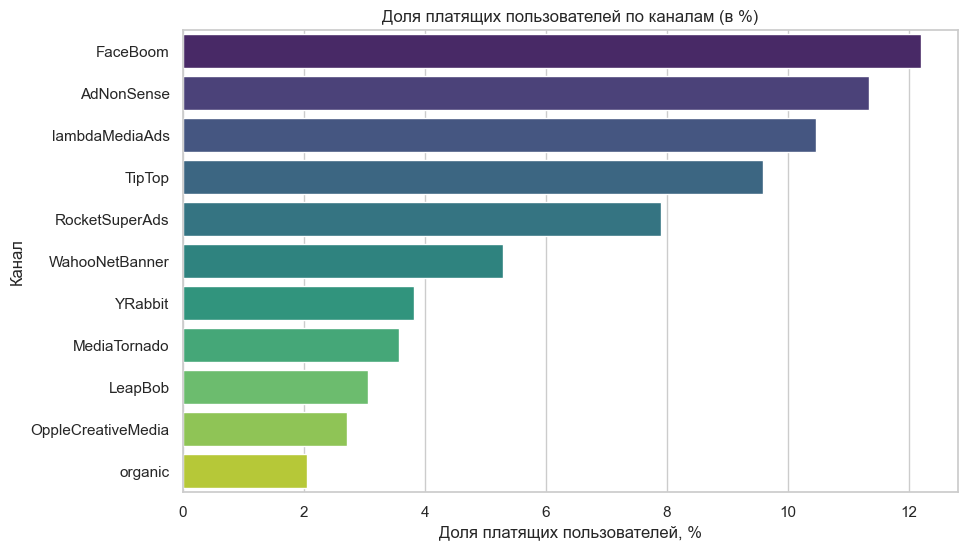

In [35]:
# Сортировка по доле платящих пользователей
channel_analysis_sorted = channel_analysis.sort_values(by='paying_ratio, %', ascending=False)

# Построение графика с долей платящих пользователей
plt.figure(figsize=(10, 6))
sns.barplot(x='paying_ratio, %', y='Channel', data=channel_analysis_sorted, palette="viridis")
plt.title('Доля платящих пользователей по каналам (в %)')
plt.xlabel('Доля платящих пользователей, %')
plt.ylabel('Канал')

Канал FaceBoom привлек значительное количество платящих пользователей с высокой долей конверсии в 12.2%. TipTop, AdNonSense и lambdaMediaAds также показывают высокие показатели по доле платящих пользователей (9.6%, 11.3% и 10.5% соответственно). В то же время, органический трафик привлек наибольшее количество пользователей, но с низкой долей платящих (2.05%), что указывает на необходимость оптимизации работы с этим каналом для повышения конверсии.

Анализ показал, что iPhone и Mac лидируют как по количеству пользователей, так и по доле платящих, особенно Mac с наибольшей долей платящих пользователей (6.4%). Среди стран Соединенные Штаты имеют наибольшее количество пользователей, а также высокую долю платящих. В то же время FaceBoom, AdNonSense и lambdaMediaAds показали наиболее высокую конверсию среди рекламных каналов, что свидетельствует о высокой эффективности этих источников привлечения.

## Маркетинг

### Общая сумма расходов на маркетинг

Посчитаем общую сумму расходов на маркетинг.

In [36]:
# Подсчет общей суммы расходов на маркетинг
total_marketing_costs = costs['costs'].sum()

# Вывод результата
print(f'Общая сумма расходов на маркетинг: {total_marketing_costs}')

Общая сумма расходов на маркетинг: 105497.30000000002


Общая сумма расходов на маркетинг составила 105 497.

### Распределение расходов по рекламным источникам

Выясним, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник. Так же отобразим процент от общих затрат.

In [37]:
# Группировка расходов по каналам и подсчет суммы для каждого канала
costs_by_channel = costs.groupby('Channel')['costs'].sum().reset_index()

# Добавление столбца с процентом затрат
costs_by_channel['percentage'] = (costs_by_channel['costs'] / total_marketing_costs) * 100

# Сортировка по величине затрат (по убыванию)
costs_by_channel = costs_by_channel.sort_values(by='costs', ascending=False).reset_index(drop=True)

costs_by_channel

Channel     costs  percentage
0              TipTop  54751.30   51.898295
1            FaceBoom  32445.60   30.754910
2      WahooNetBanner   5151.00    4.882589
3          AdNonSense   3911.25    3.707441
4  OppleCreativeMedia   2151.25    2.039152
5      RocketSuperAds   1833.00    1.737485
6             LeapBob   1797.60    1.703930
7      lambdaMediaAds   1557.60    1.476436
8        MediaTornado    954.48    0.904744
9             YRabbit    944.22    0.895018

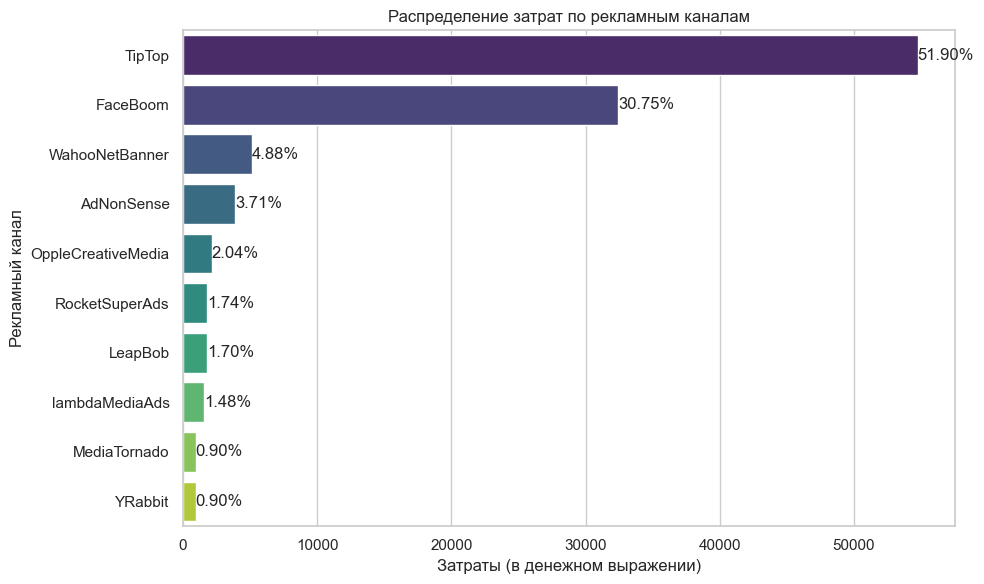

In [38]:
# Добавим график с отображением результаттов

# Построение графика затрат по рекламным каналам
plt.figure(figsize=(10, 6))
sns.barplot(x='costs', y='Channel', data=costs_by_channel, palette="viridis")

# Добавление аннотаций процентов на график
for index, value in enumerate(costs_by_channel['costs']):
    percentage = costs_by_channel['percentage'].iloc[index]
    plt.text(value, index, f'{percentage:.2f}%', va='center')

plt.title('Распределение затрат по рекламным каналам')
plt.xlabel('Затраты (в денежном выражении)')
plt.ylabel('Рекламный канал')

# Показать график
plt.tight_layout()
plt.show()

Основная часть маркетинговых расходов приходится на каналы TipTop и FaceBoom, на которые было потрачено 54,751.30 и 32,445.60 соответственно. Это составляет 82.65% от всей суммы расходов. Остальные каналы требуют значительно меньших затрат, причем самый низкий уровень расходов наблюдается на каналах MediaTornado и YRabbit. 

###  Динамика изменения расходов

Построим график с визуализацией динамики изменения расходов во времени по неделям по каждому источнику. <br>
Затем на другом графике визуализируем динамику изменения расходов во времени по месяцам по каждому источнику.<br>
Для изучения динамики во времени лучше всего использовать линейный график, так что построим именно его.

In [39]:
# Преобразуем столбец dt в формат datetime, чтобы извлечь неделю и месяц. (после преобразования выше .dt.date тип остается object)
costs['dt'] = pd.to_datetime(costs['dt'])

# Добавляем столбцы с неделей и месяцем
costs['week'] = costs['dt'].dt.to_period('W').apply(lambda r: r.start_time)
costs['month'] = costs['dt'].dt.to_period('M').apply(lambda r: r.start_time)

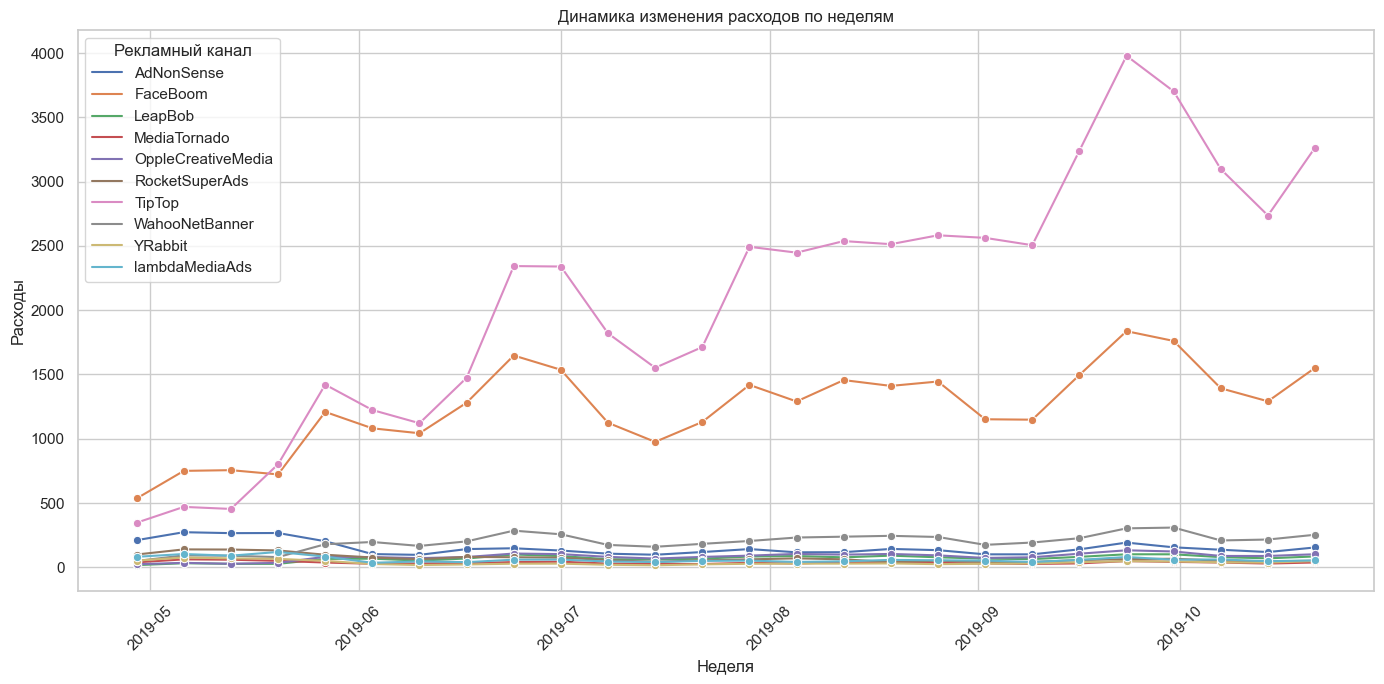

In [40]:
# Группировка данных по неделям и рекламным каналам
weekly_costs = costs.groupby(['week', 'Channel'])['costs'].sum().reset_index()

# Построение графика
plt.figure(figsize=(14, 7))
sns.lineplot(x='week', y='costs', hue='Channel', data=weekly_costs, marker='o')
plt.title('Динамика изменения расходов по неделям')
plt.xlabel('Неделя')
plt.ylabel('Расходы')
plt.legend(title='Рекламный канал')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

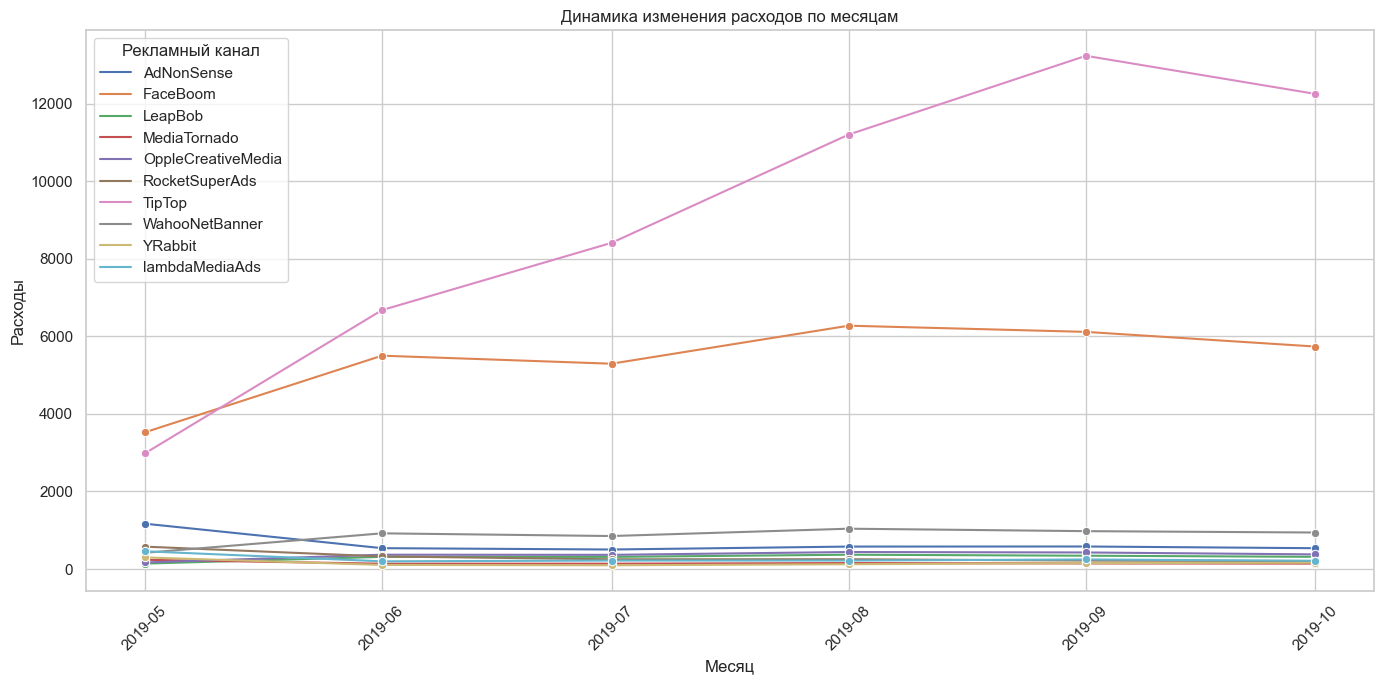

In [41]:
# Группировка данных по месяцам и рекламным каналам
monthly_costs = costs.groupby(['month', 'Channel'])['costs'].sum().reset_index()

# Построение графика
plt.figure(figsize=(14, 7))
sns.lineplot(x='month', y='costs', hue='Channel', data=monthly_costs, marker='o')
plt.title('Динамика изменения расходов по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Расходы')
plt.legend(title='Рекламный канал')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

По графикам можно сделать вывод, что значительные затраты сконцентрированы на рекламных каналах TipTop и FaceBoom. Эти каналы демонстрируют устойчивый рост расходов в течение анализируемого периода, особенно заметный по месячной динамике. В то время как другие каналы имеют существенно меньшие бюджеты и расходы остаются относительно стабильными на протяжении всего периода, TipTop выделяется резким увеличением затрат, начиная с июня и заканчивая пиком в сентябре.

### Расчет CAC

Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. <br>
Будем использовать профили пользователей.

In [42]:
# Исключаем органических пользователей из профилей
profiles = profiles[profiles['Channel'] != 'organic']

# Группировка и вычисление среднего acquisition_cost по каждому каналу
cac_by_channel = profiles.groupby('Channel')['acquisition_cost'].mean().reset_index()

# Переименование столбца для наглядности
cac_by_channel = cac_by_channel.rename(columns={'acquisition_cost': 'CAC'})

# Средний CAC по всему проекту
average_cac = profiles['acquisition_cost'].mean()

# Добавление столбца со средним CAC в таблицу
cac_by_channel['Average CAC'] = average_cac

# Сортировка по величине CAC
cac_by_channel = cac_by_channel.sort_values(by='CAC', ascending=False).reset_index(drop=True)
cac_by_channel

Channel       CAC  Average CAC
0              TipTop  2.799003     1.127481
1            FaceBoom  1.113286     1.127481
2          AdNonSense  1.008054     1.127481
3      lambdaMediaAds  0.724802     1.127481
4      WahooNetBanner  0.602245     1.127481
5      RocketSuperAds  0.412095     1.127481
6  OppleCreativeMedia  0.250000     1.127481
7             YRabbit  0.218975     1.127481
8        MediaTornado  0.218717     1.127481
9             LeapBob  0.210172     1.127481

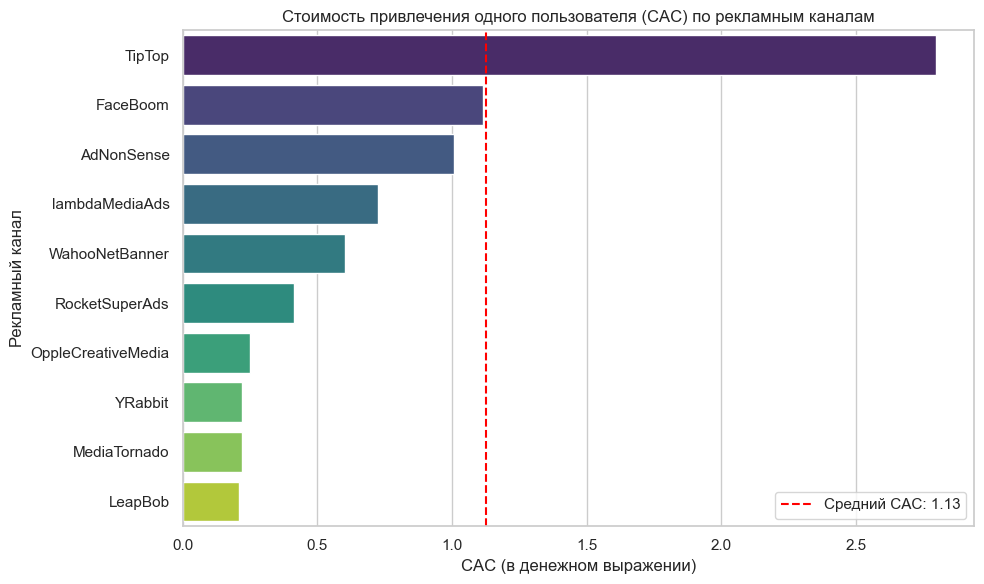

In [43]:
# Построение графика CAC по рекламным каналам
plt.figure(figsize=(10, 6))
sns.barplot(x='CAC', y='Channel', data=cac_by_channel, palette="viridis")

# Добавление линии среднего CAC
plt.axvline(average_cac, color='red', linestyle='--', label=f'Средний CAC: {average_cac:.2f}')

# Добавление легенды
plt.legend()

plt.title('Стоимость привлечения одного пользователя (CAC) по рекламным каналам')
plt.xlabel('CAC (в денежном выражении)')
plt.ylabel('Рекламный канал')

# Показать график
plt.tight_layout()
plt.show()

Рекламные каналы TipTop и FaceBoom имеют самые высокие показатели стоимости привлечения одного пользователя (CAC), составляя 2.8 и 1.11 соответственно. В то же время, органический трафик имеет нулевой CAC, что логично, поскольку он не требует прямых затрат на привлечение. Наиболее экономичными платными каналами оказались LeapBob и MediaTornado с CAC около 0.21.

Анализ маркетинговых расходов показал, что основные затраты сосредоточены на каналах TipTop и FaceBoom, которые требуют значительных бюджетов, но также демонстрируют высокий CAC. Это свидетельствует о том, что хотя эти каналы привлекают много пользователей, затраты на каждого из них выше среднего, что может повлиять на общую рентабельность (пока что предположение).

В то же время, органический трафик остается наиболее экономичным источником пользователей с нулевым CAC, но доля платящих пользователей среди органических посетителей невелика. Более экономичные платные каналы, такие как LeapBob и MediaTornado, демонстрируют значительно более низкий CAC, что делает их привлекательными с точки зрения затрат на привлечение.

## Оценка окупаемости рекламы

Используя графики LTV, ROI и CAC, проанализируем окупаемость рекламы.<br>
Будем считать, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения.<br>

Исключим из анализа органических пользователей, чтобы получить полное представление о поведении всех пользователей, которые были привлечены  платно.

### Окупаемость рекламы

Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.

In [44]:
# Устанавливаем дату наблюдения
observation_date = datetime(2019, 11, 1).date()

# Устанавливаем горизонт анализа в 14 дней
horizon_days = 14

# Исключаем органических пользователей из профилей
profiles = profiles[profiles['Channel'] != 'organic']

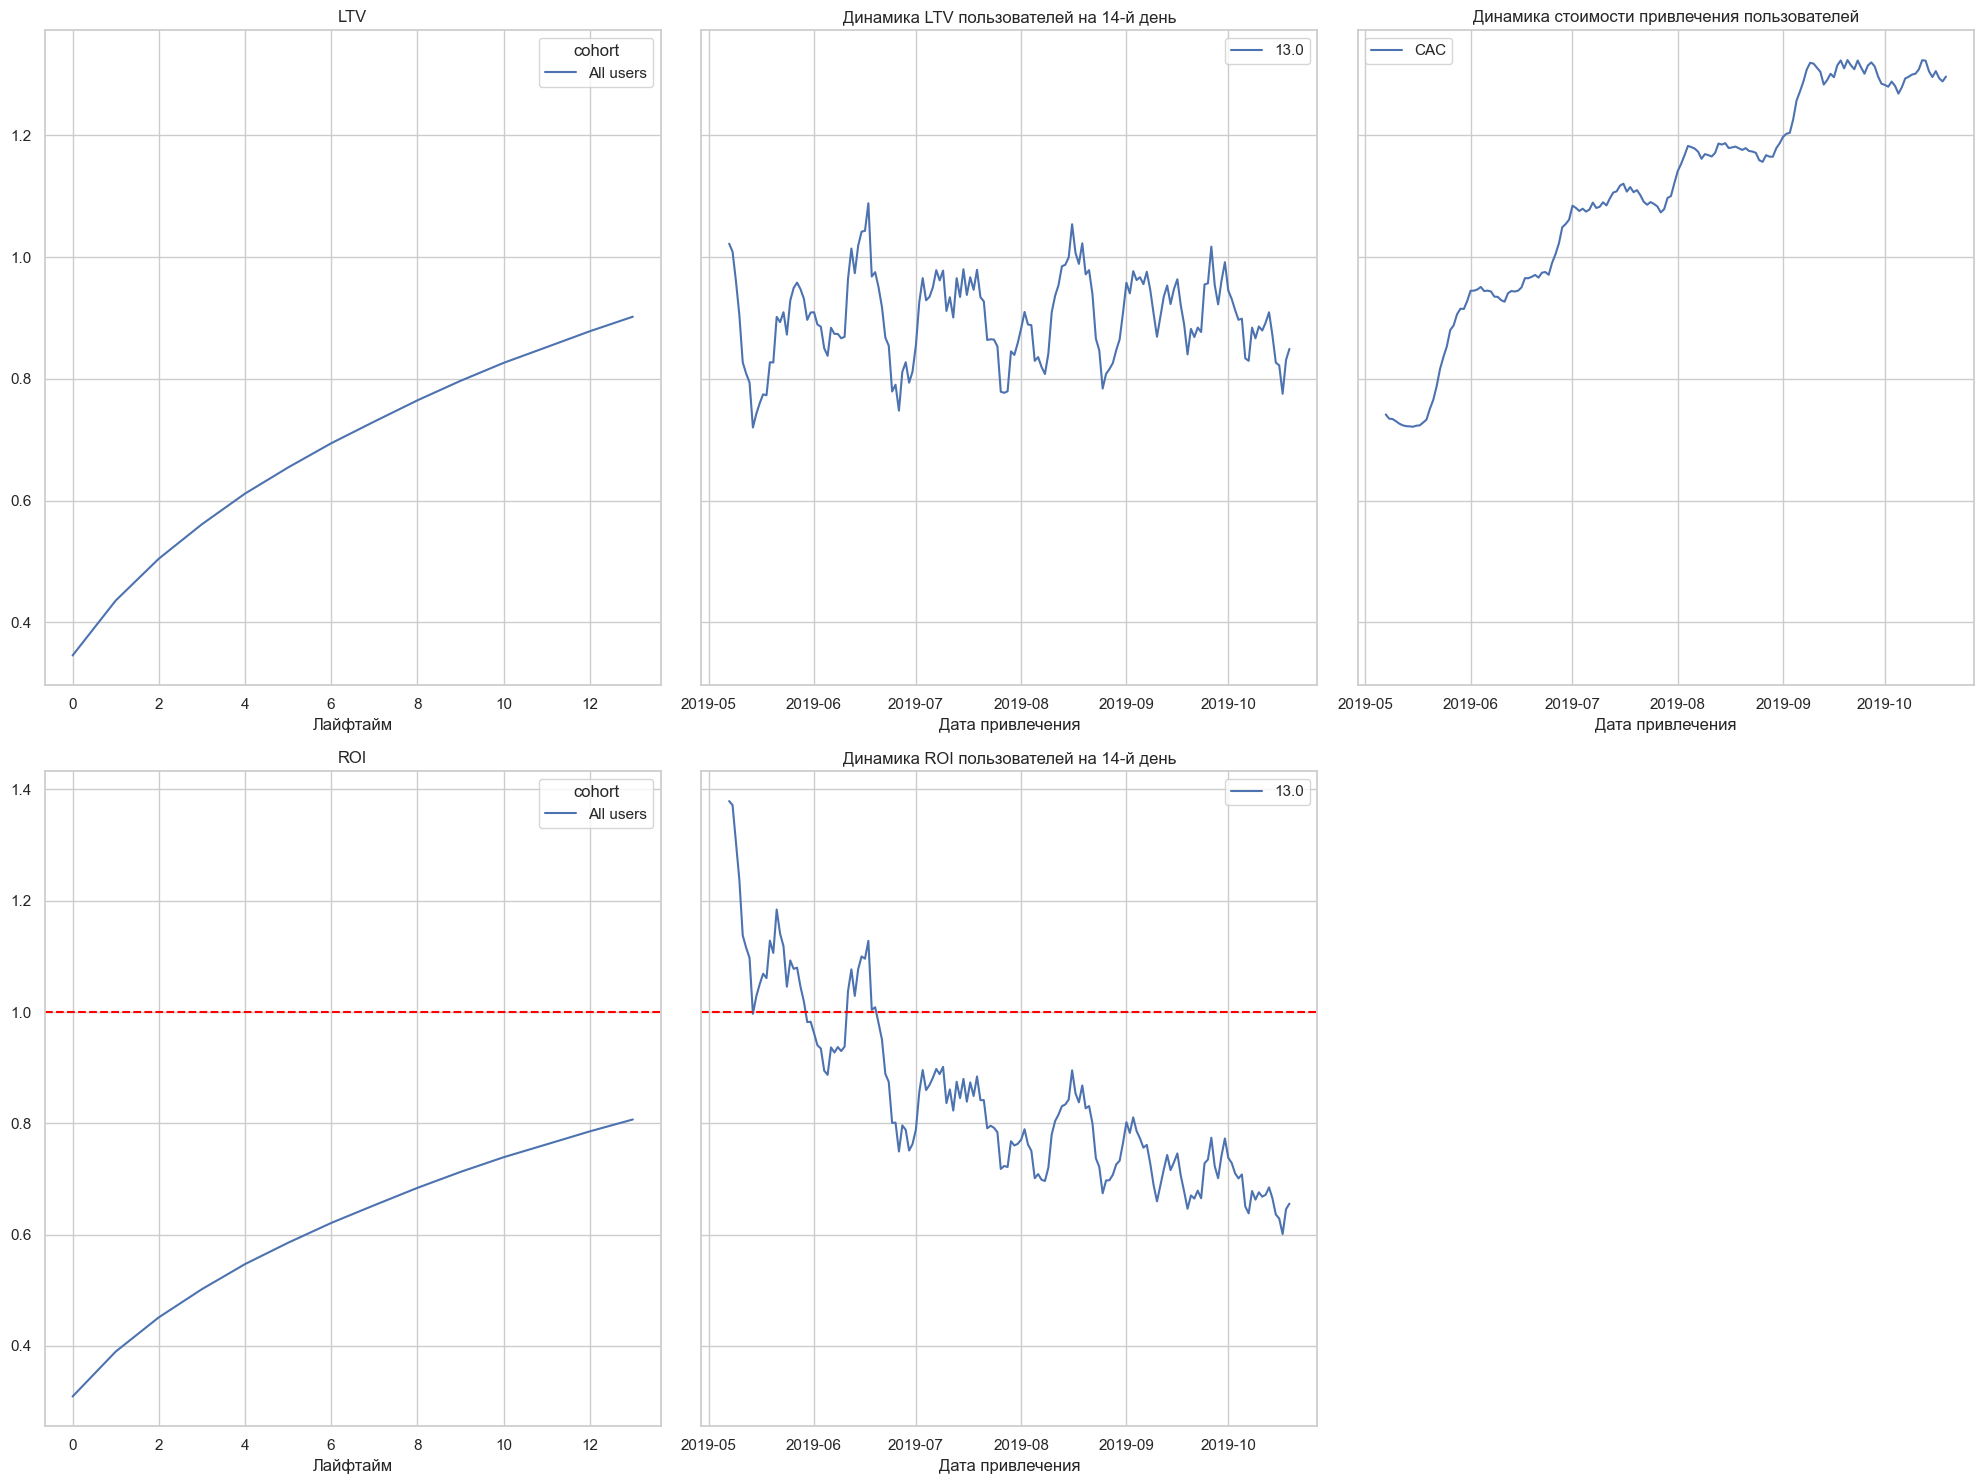

In [45]:
# Расчет LTV и ROI для пользователей, привлеченных до 1 ноября 2019 года
ltv_data, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles=profiles,
    purchases=orders,
    observation_date=observation_date,
    horizon_days=horizon_days
)

# Построение графиков для LTV, CAC, ROI
plot_ltv_roi(ltv=ltv_grouped, ltv_history=ltv_history, roi=roi_grouped, roi_history=roi_history, horizon=horizon_days)

- График LTV демонстрирует стабильный рост на протяжении первых 14 дней. Это подтверждает, что пользователи продолжают приносить доход в течение этого периода, однако суммарный LTV на 14-й день составляет около 0,9, что указывает на ограниченный доход с одного пользователя;
- Динамика LTV на 14-й день показывает существенные колебания, особенно в период с июня по октябрь 2019 года. Это может указывать на эффективность определенных маркетинговых кампаний в эти периоды, которые привлекли пользователей с более высоким уровнем дохода. Однако после октября 2019 года наблюдается тенденция к снижению LTV;
- Стоимость привлечения пользователей (CAC) значительно выросла с мая по октябрь 2019 года. Особенно сильный скачок виден в июне. В сентябре и октябре 2019 года CAC стабилизировался на высоком уровне, что требует оптимизации затрат на привлечение пользователей;
- В течение первых 14 дней возврат на инвестиции (ROI) постепенно увеличивается, но остается сильно ниже уровня окупаемости (1). Это говорит о том, что, хотя доход с пользователя растет с течением времени, для достижения полной окупаемости требуется более длительный период;
- Динамика ROI показывает устойчивое снижение, начиная с июня 2019 года, и больше не поднимается до уровня окупаемости. Это свидетельствует о том, что со временем эффективность маркетинговых кампаний ухудшалась, а затраты на привлечение стали превышать доходы, приходящие от пользователей.

### Конверсия пользователей

Проверим конверсию пользователей и динамику её изменения. То же самое сделаем с удержанием пользователей.<br>
Построим и изучим графики конверсии и удержания.

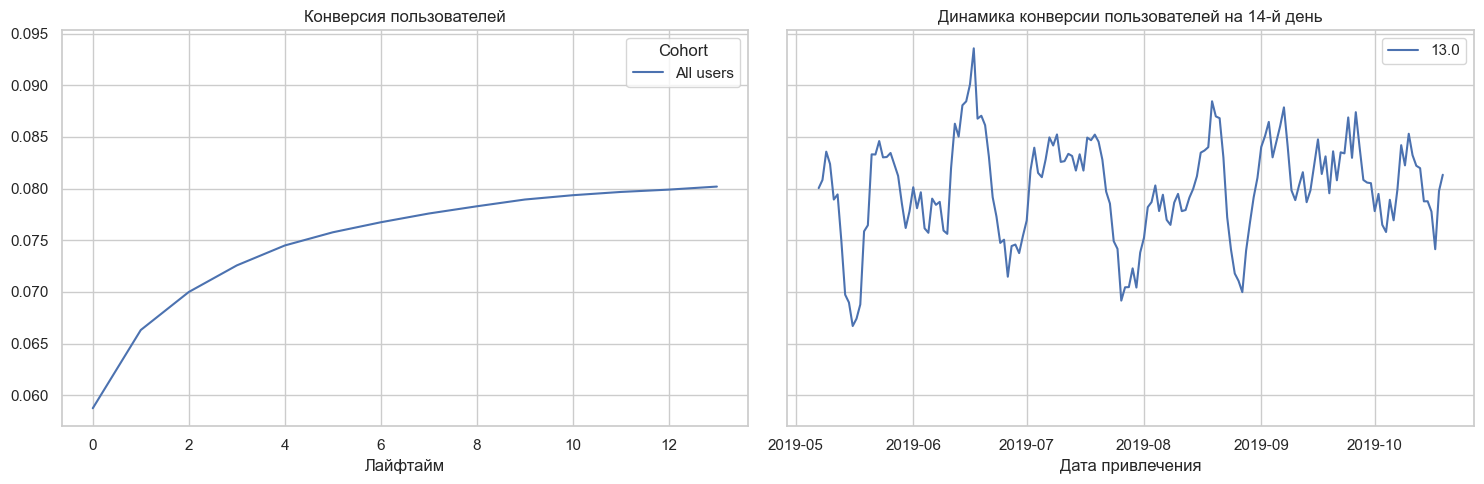

In [46]:
# Расчет конверсии пользователей
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles=profiles,
    purchases=orders,
    observation_date=observation_date,
    horizon_days=horizon_days
)

# Построение графиков конверсии и динамики ее изменения
plot_conversion(conversion=conversion_grouped, conversion_history=conversion_history, horizon=horizon_days)

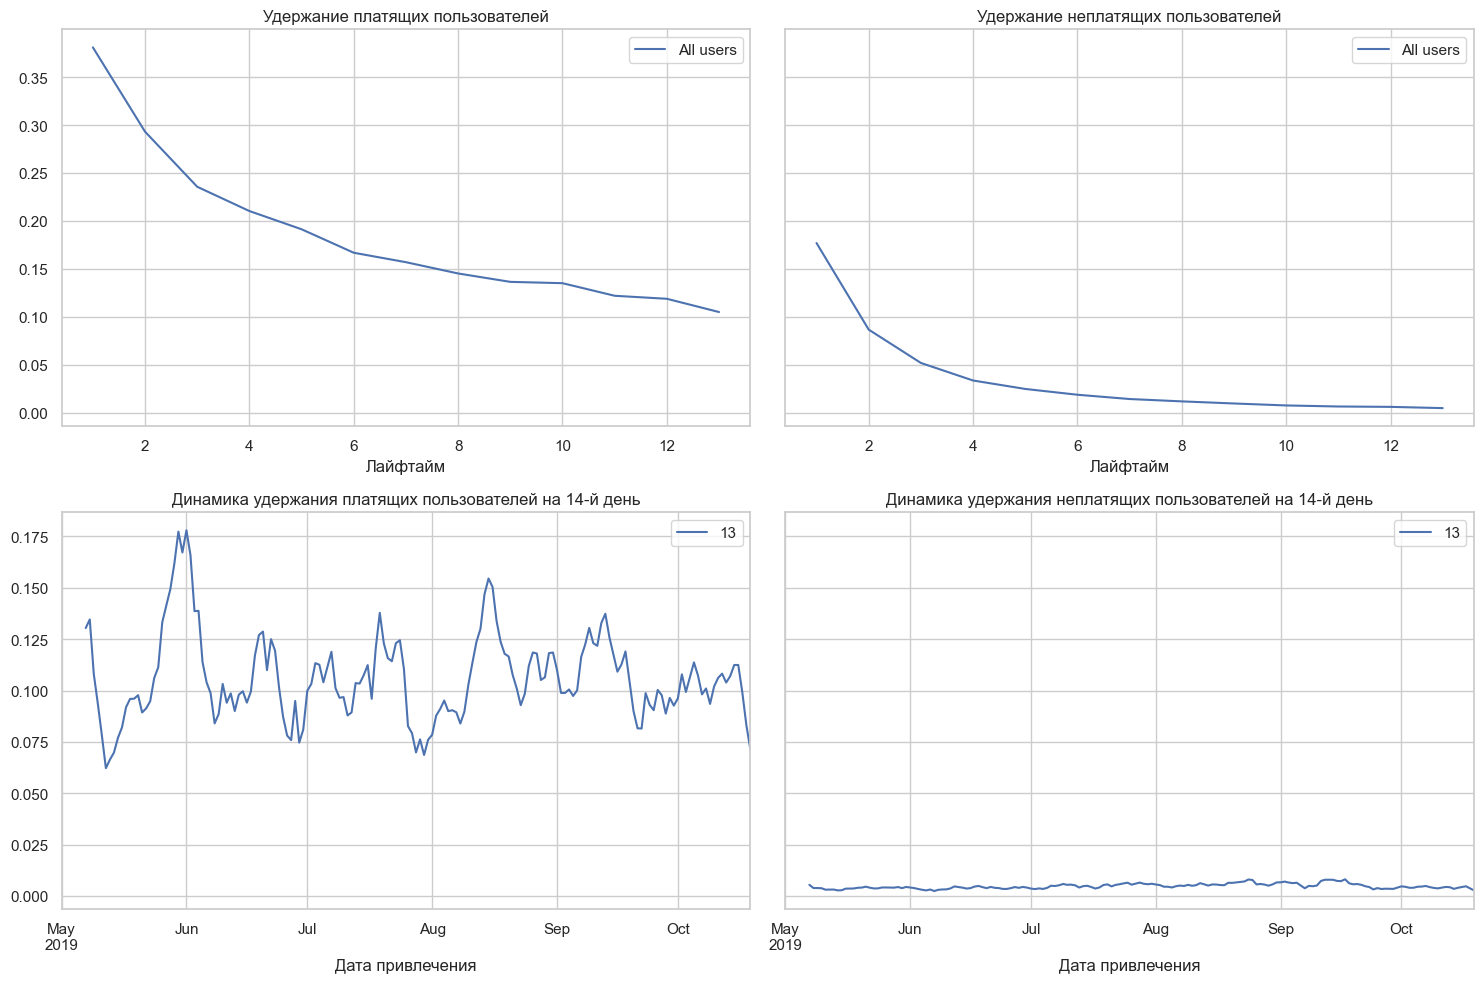

In [47]:
# Расчет удержания пользователей
retention_raw, retention_grouped, retention_history = get_retention(
    profiles=profiles,
    sessions=visits,
    observation_date=observation_date,
    horizon_days=horizon_days
)

# Построение графиков удержания и динамики его изменения
plot_retention(retention=retention_grouped, retention_history=retention_history, horizon=horizon_days)

- График конверсии показывает, что на 14-й день конверсия пользователей составляет около 8%. Это означает, что из всех пользователей, которые начали использовать приложение, около 8% становятся платящими в течение первых двух недель;
- Динамика конверсии на 14-й день показывает значительные колебания. В периоды июня и сентября 2019 года наблюдаются пики конверсии, что может свидетельствовать о том, что в эти периоды маркетинговые кампании были более эффективными. Однако с октября конверсия начала снижаться, что может требовать дальнейшего анализа и корректировки маркетинговой стратегии;
- График удержания платящих пользователей показывает, что на первом дне после привлечения около 37% пользователей остаются активными. Однако к 14-му дню удержание значительно снижается и составляет менее 15%. Это указывает на то, что большинство платящих пользователей покидают приложение в первые две недели;
- Динамика удержания платящих пользователей на 14-й день также показывает значительные колебания, с несколькими пиками и спадами в течение анализируемого периода. В октябре 2019 года наблюдается снижение удержания;
- График удержания неплатящих пользователей показывает, что большинство из них прекращают использование приложения уже в первые дни. На 14-й день активными остаются лишь незначительное количество пользователей, что указывает на низкий уровень вовлеченности среди тех, кто не стал платящим;
- Динамика удержания неплатящих пользователей практически не меняется на протяжении периода, что говорит о стабильности поведения этой группы, но на очень низком уровне вовлеченности.

### Окупаемость рекламы с разбивкой по устройствам

Проанализируем окупаемость рекламы с разбивкой по устройствам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

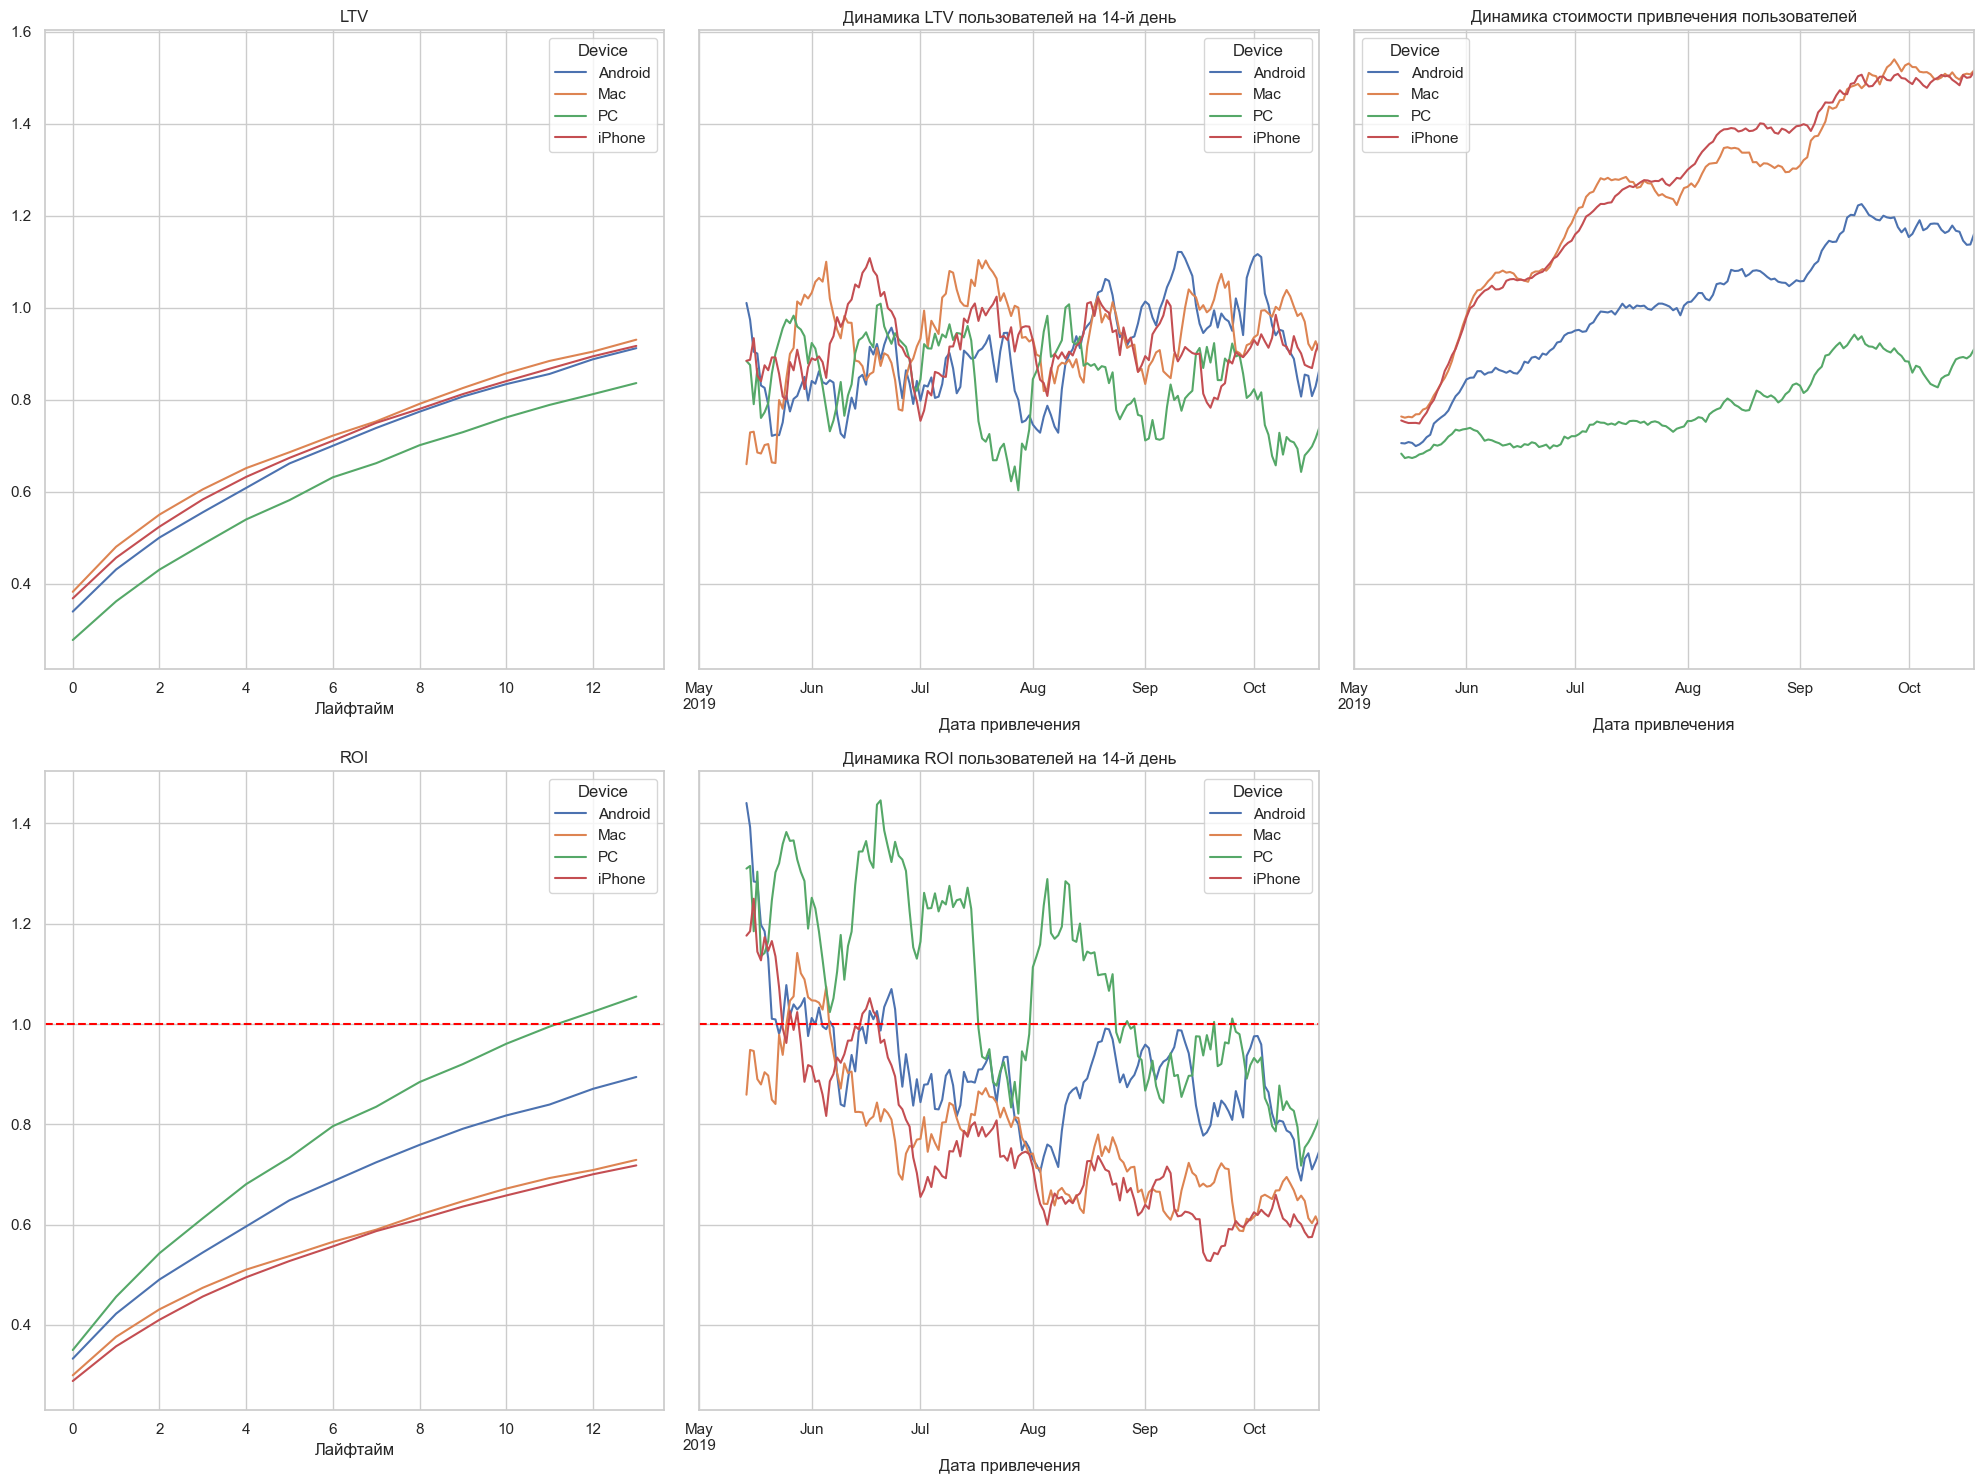

In [48]:
# Устанавливаем параметры разбиения по устройствам
dimensions = ['Device']

ltv_data, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles=profiles,
    purchases=orders,
    observation_date=observation_date,
    horizon_days=horizon_days,
    dimensions=dimensions
)

# Построение графиков LTV и ROI с разбиением по устройствам
plot_ltv_roi(ltv=ltv_grouped, ltv_history=ltv_history, roi=roi_grouped, roi_history=roi_history, horizon=horizon_days, window=14)

- Наибольший LTV (средняя выручка с пользователя за период времени) показывают пользователи устройств Mac, iPhone и Android, а пользователи PC имеют наименьший LTV;
- Динамика LTV показывает колебания для всех устройств. Однако несмотря на колебания, общая тенденция показывает рост LTV с течением времени для всех устройств;
- Стоимость привлечения пользователей (CAC) значительно выше для пользователей iPhone и Mac, что может быть связано с высокой конкуренцией на этих платформах и большими затратами на рекламу. Пользователи PC имеют самый низкий CAC;
- Пользователи PC показывают лучший рост ROI, достигая уроня окупаемости примерно на 12 день. Пользователи Android, Mac и iPhone отметка не доходит до окупаемости в заданном периоде. Наихудшие результаты показывают Mac и iPhone;
- Динамика ROI показывает устойчивое снижение, к концу периода все пользователи ниже отметки окупаемости. Пользователи Mac и iPhone снова показывают худший результат, находятся сильно ниже отметки окупаесости с июля.

### Конверсия пользователей с разбивкой по устройствам

Проверим конверсию пользователей с разбивкой по устройствам и динамику её изменения. То же самое сделаем с удержанием пользователей.
Построим и изучим графики конверсии и удержания.

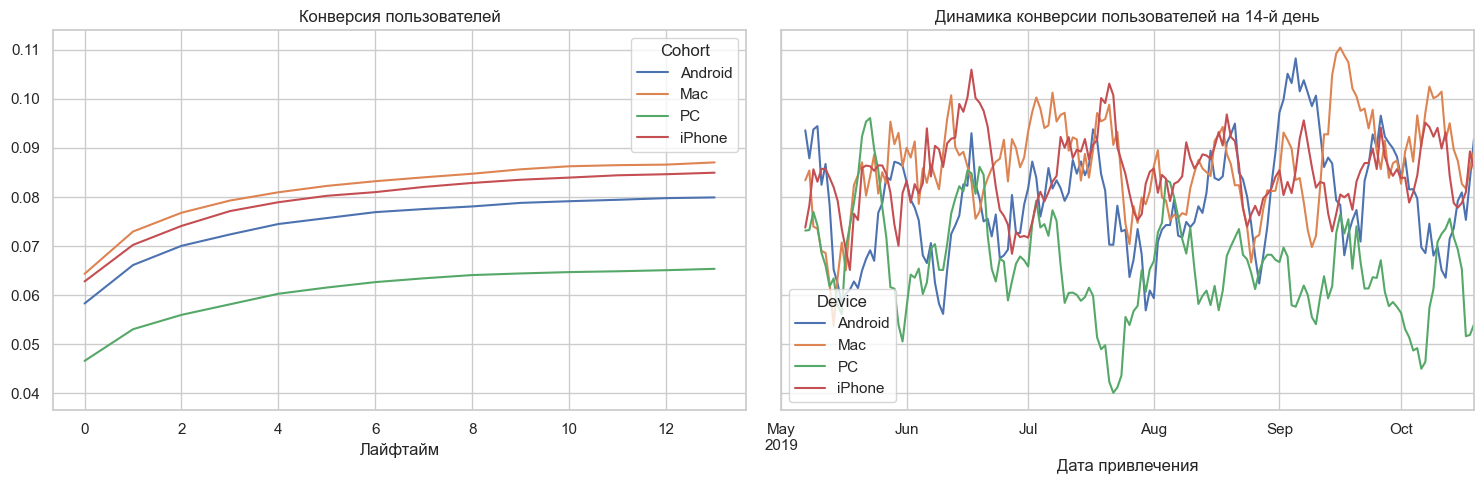

In [49]:
# Устанавливаем параметры разбиения по устройствам
dimensions = ['Device']

# Расчет конверсии пользователей
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles=profiles,
    purchases=orders,
    observation_date=observation_date,
    horizon_days=horizon_days,
    dimensions = dimensions
)

# Построение графиков конверсии и динамики ее изменения
plot_conversion(conversion=conversion_grouped, conversion_history=conversion_history, horizon=horizon_days)

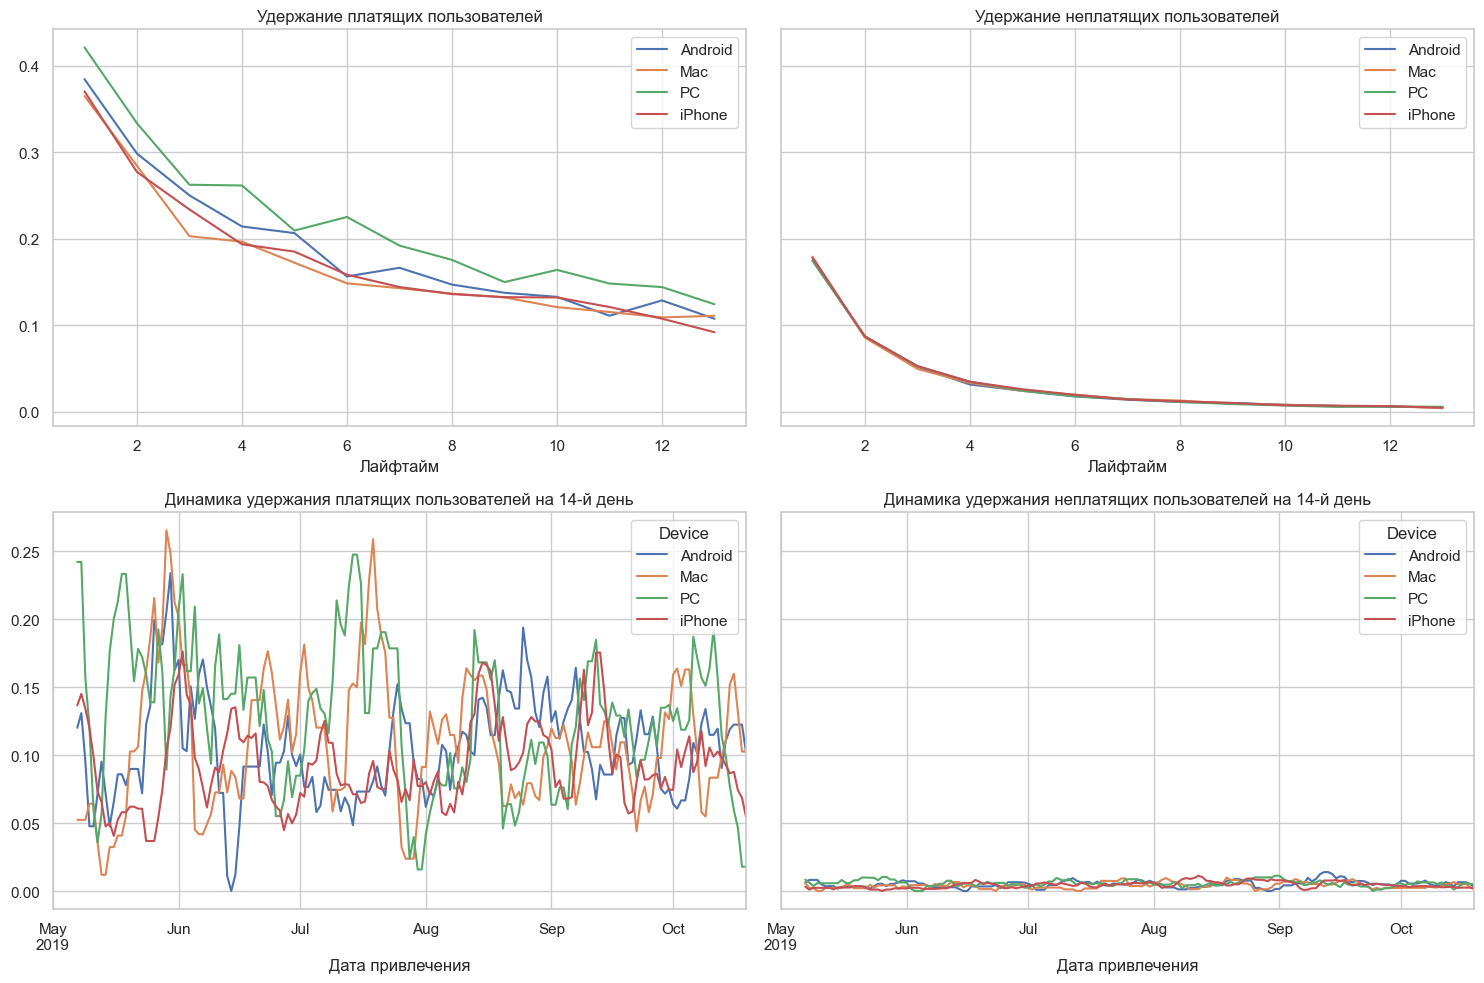

In [50]:
# Расчет удержания пользователей
retention_raw, retention_grouped, retention_history = get_retention(
    profiles=profiles,
    sessions=visits,
    observation_date=observation_date,
    horizon_days=horizon_days,
    dimensions = dimensions
)

# Построение графиков удержания и динамики его изменения
plot_retention(retention=retention_grouped, retention_history=retention_history, horizon=horizon_days)

- Все пользователи показывают сравнительно похожую конверсию, пользователи PC немного проигрывают остальным;
- По удержанию платящих и неплатящих нельзя выявить явных проблем, все пользователи ведут себя примерно одинаково.

### Окупаемость рекламы с разбивкой по странам

Проанализируем окупаемость рекламы с разбивкой по странам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

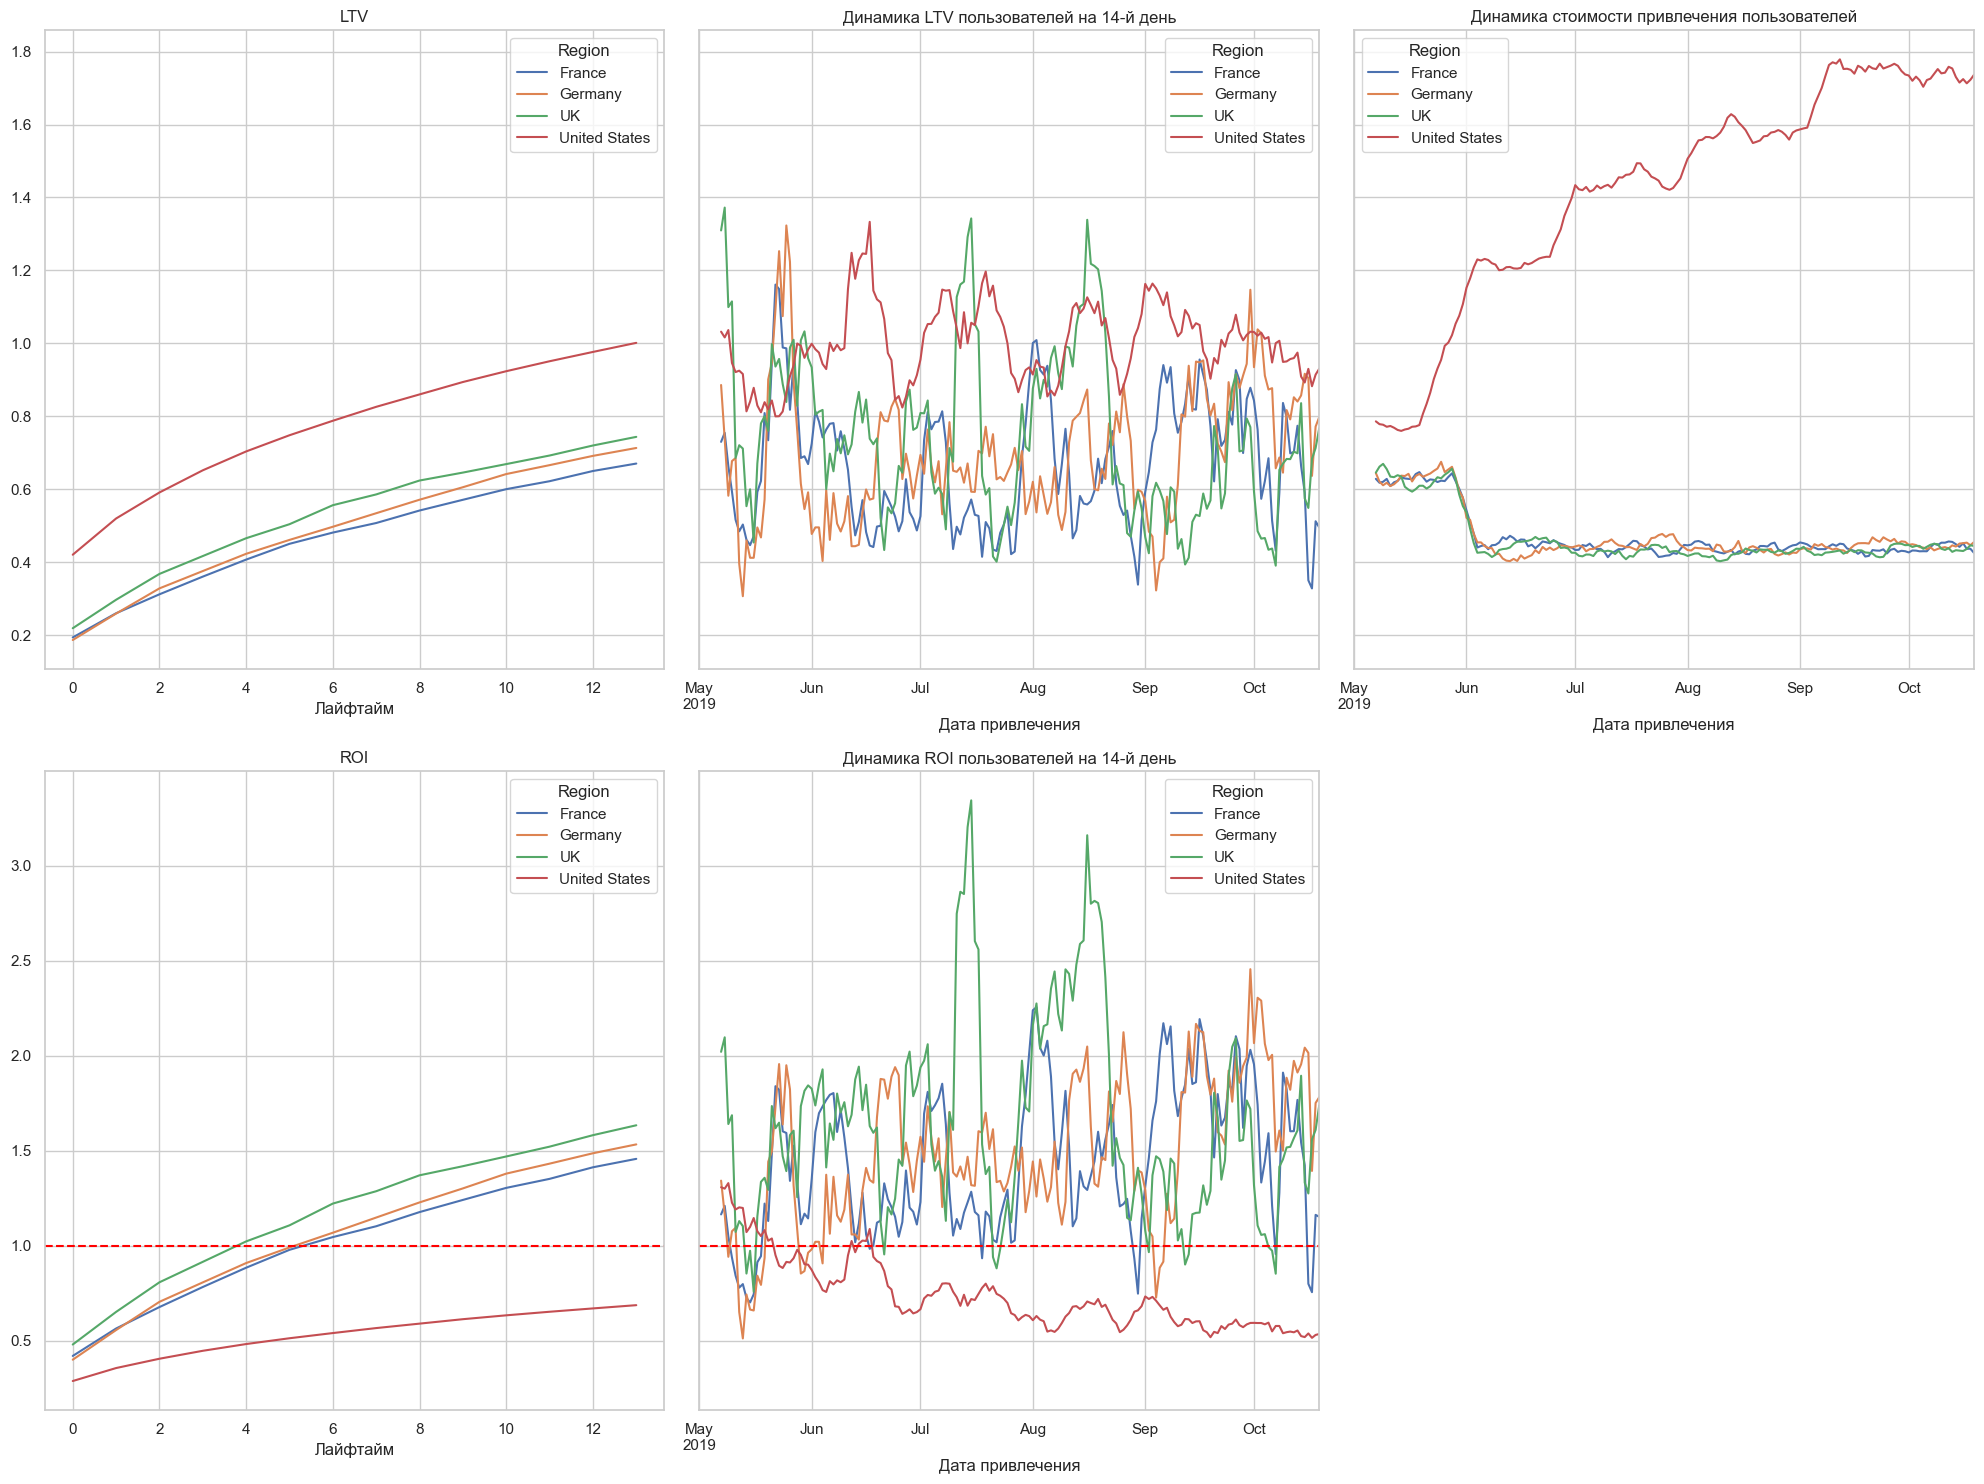

In [51]:
# Устанавливаем параметры разбиения по странам
dimensions = ['Region']

# Расчет LTV и ROI для пользователей с разбивкой по странам
ltv_data, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles=profiles,
    purchases=orders,
    observation_date=observation_date,
    horizon_days=horizon_days,
    dimensions=dimensions
)

# Построение графиков LTV и ROI с разбиением по странам
plot_ltv_roi(ltv=ltv_grouped, ltv_history=ltv_history, roi=roi_grouped, roi_history=roi_history, horizon=horizon_days)

- Пользователи из США имеют наивысший LTV по сравнению с другими странами;
- Динамика LTV показывает значительные колебания для всех стран;
- Стоимость привлечения пользователей из США значительно выше, чем в других странах, особенно после скачка в июне. После CAC для пользователей США имеет стабильный рост, а в остальных странах CAC падает в июне и далее держится на одном уровне;
- Самый выскоий ROI показывает Англия, достигая уровень окупаемости на 4 день. Германия и Франция тоже имеют сравнительно высокий ROI, достигая уровень окупаемости примерно на 5 день. Наименьший показатель у США, отметка так и не доходит до окупаемости за весь период;
- Динамика ROI показывает значительные колебания для всех стран. В США ROI остается стабильно низким, что подтверждает выводы о высокой стоимости привлечения и низкой окупаемости.

### Конверсия пользователей с разбивкой по странам

Проверим конверсию пользователей с разбивкой по странам и динамику её изменения. То же самое сделаем с удержанием пользователей. Построим и изучим графики конверсии и удержания.

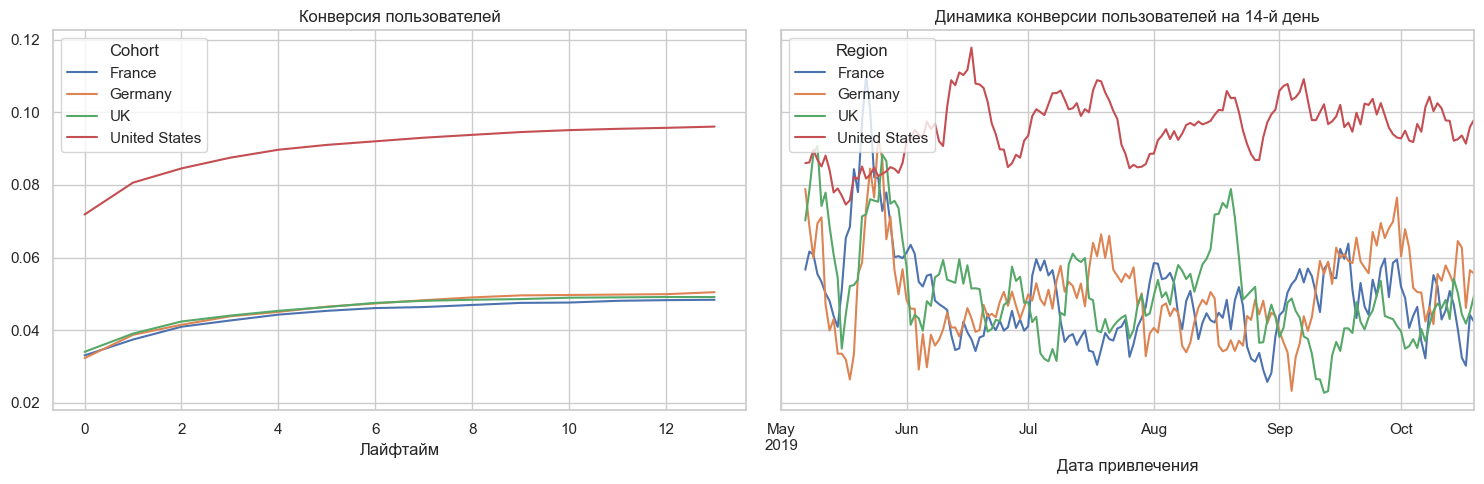

In [52]:
# Устанавливаем параметры разбиения по устройствам
dimensions = ['Region']

# Расчет конверсии пользователей
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles=profiles,
    purchases=orders,
    observation_date=observation_date,
    horizon_days=horizon_days,
    dimensions = dimensions
)

# Построение графиков конверсии и динамики ее изменения
plot_conversion(conversion=conversion_grouped, conversion_history=conversion_history, horizon=horizon_days)

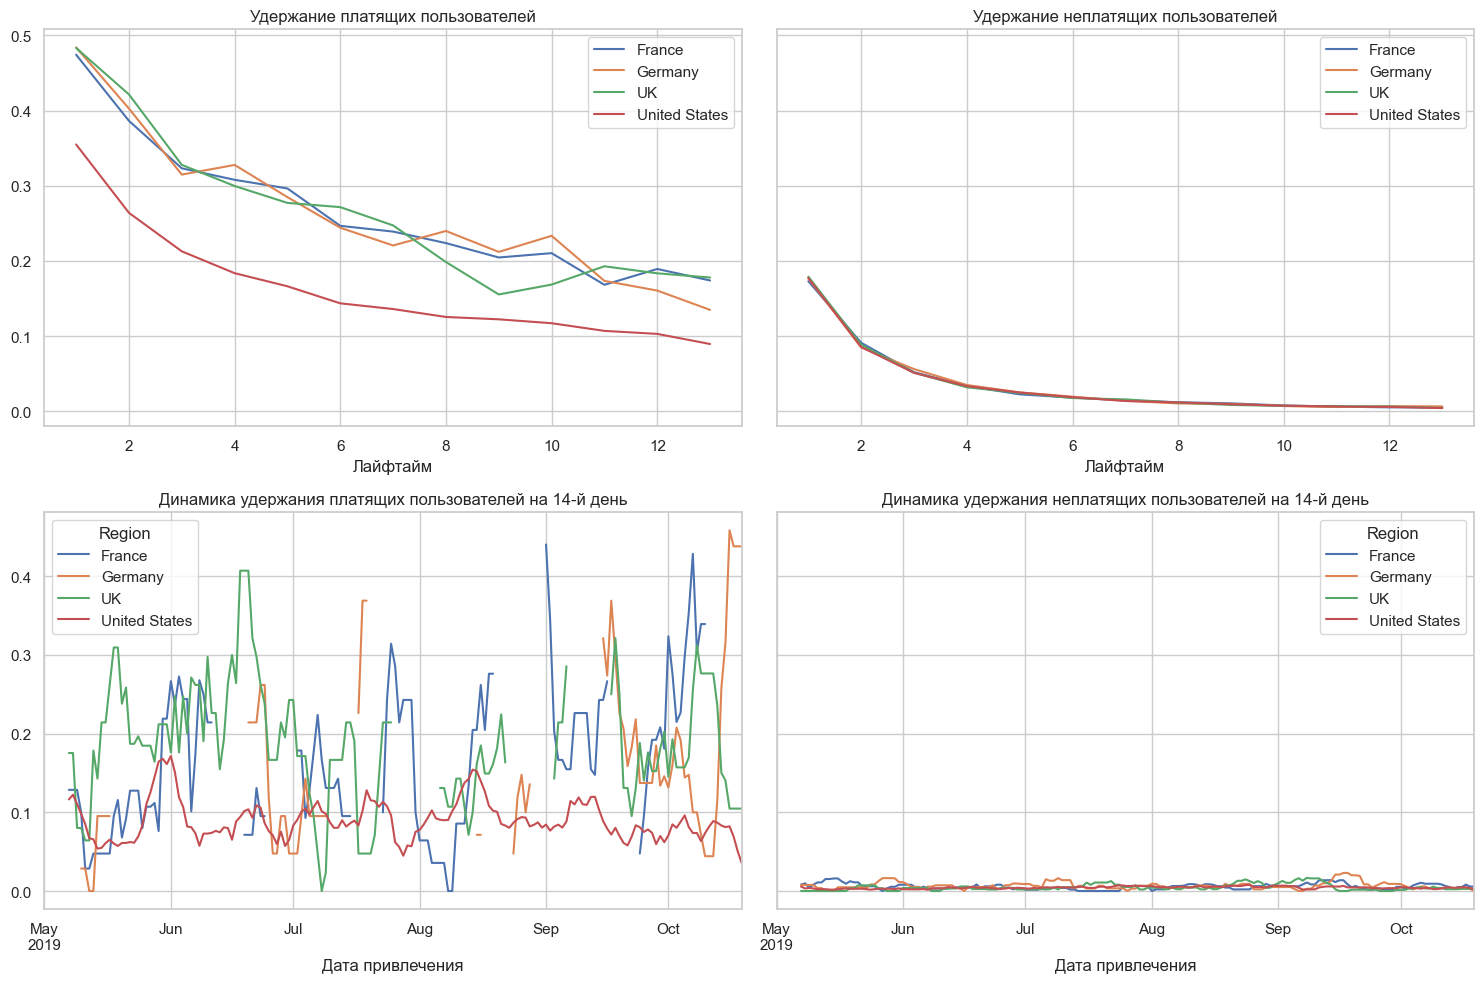

In [53]:
# Расчет удержания пользователей
retention_raw, retention_grouped, retention_history = get_retention(
    profiles=profiles,
    sessions=visits,
    observation_date=observation_date,
    horizon_days=horizon_days,
    dimensions = dimensions
)

# Построение графиков удержания и динамики его изменения
plot_retention(retention=retention_grouped, retention_history=retention_history, horizon=horizon_days)

- Конверсия пользователей США примерно в 2 раза выше остальных;
- Удержание платящих пользователей ниже у США, остальные показатели примерно одинаковы у всех пользователей.

### Окупаемость рекламы с разбивкой по рекламным каналам

Проанализируем окупаемость рекламы с разбивкой по рекламным каналам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

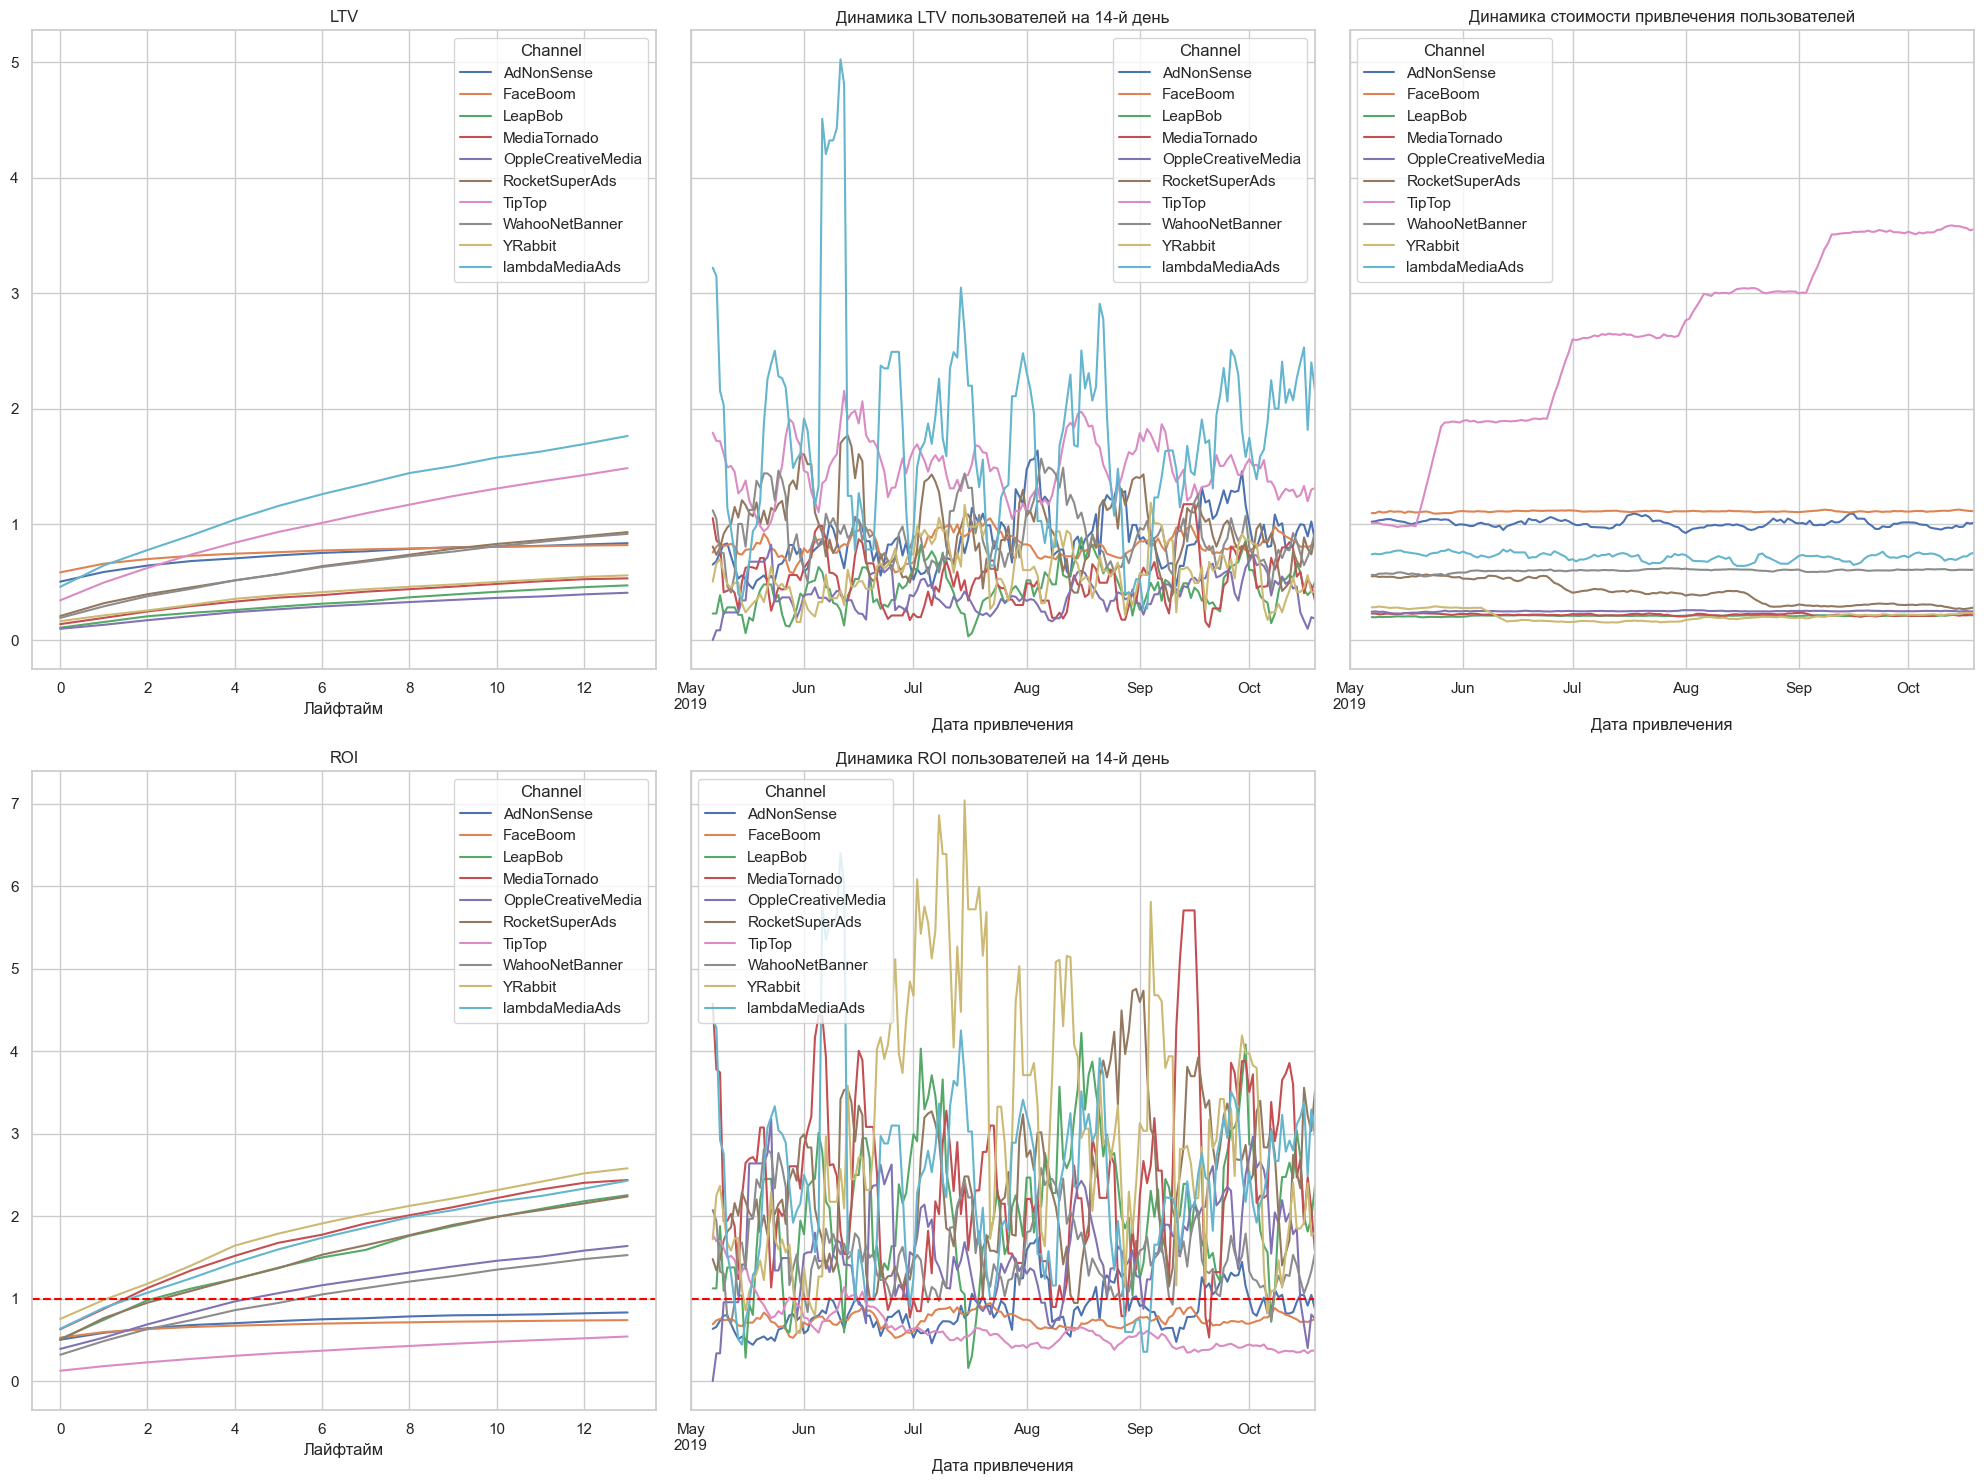

In [54]:
# Устанавливаем параметры разбиения по каналам
dimensions = ['Channel']

# Расчет LTV и ROI для пользователей с разбивкой по каналам
ltv_data, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles=profiles,
    purchases=orders,
    observation_date=observation_date,
    horizon_days=horizon_days,
    dimensions=dimensions
)

# Построение графиков LTV и ROI с разбиением по каналам
plot_ltv_roi(ltv=ltv_grouped, ltv_history=ltv_history, roi=roi_grouped, roi_history=roi_history, horizon=horizon_days)

- Наилучший LTV показывают lambdaMediaAds и TipTop. Динамика LTV имеет значительные колебания, особенно у lambdaMediaAds.
- CAC по всем каналам достаточно стабильный, кроме TipTop, который увеличивается скачками каждый месяц.
- Практически все каналы имеют ROI выше уровня окупаемости, кроме AdNonSense и FaceBoom, которые почти доходят до уровня окупаемости к концу периода, а так же TipTop, у которого наименьший ROI среди всех каналов. Динамика ROI у этих каналов достаточно стабильная, ниже льметки окупаемости за весь период анализа. У остальных каналов динамика показывает значительные колебания.

### Конверсия пользователей с разбивкой по рекламным каналам

Проверим конверсию пользователей с разбивкой по рекламным каналам и динамику её изменения. То же самое сделаем с удержанием пользователей. Построим и изучим графики конверсии и удержания.

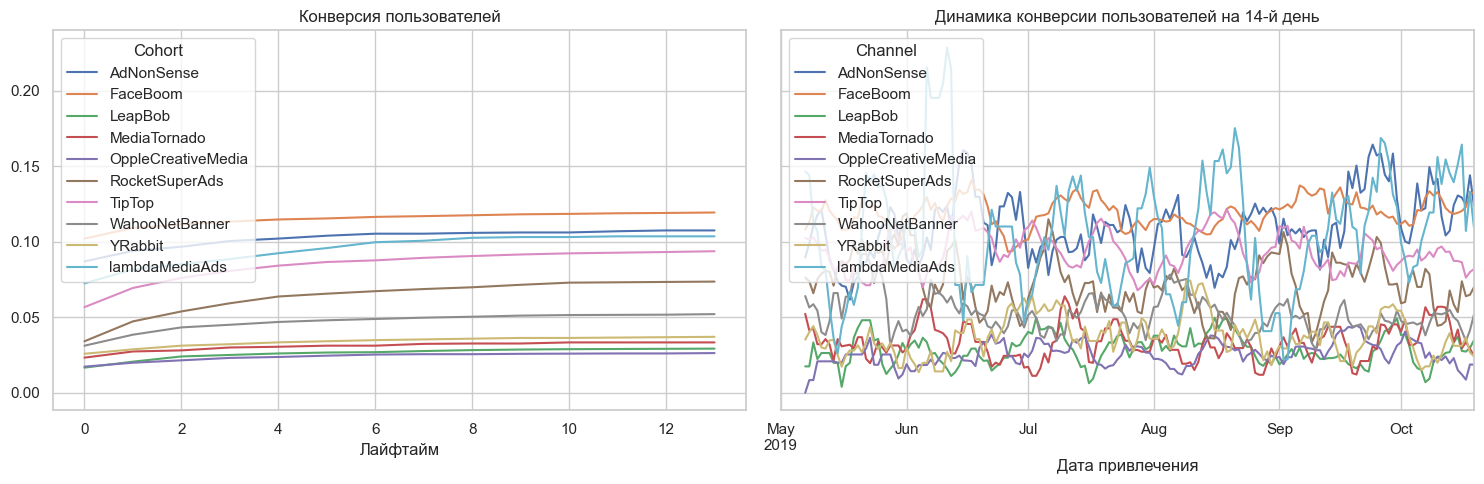

In [55]:
# Устанавливаем параметры разбиения по устройствам
dimensions = ['Channel']

# Расчет конверсии пользователей
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles=profiles,
    purchases=orders,
    observation_date=observation_date,
    horizon_days=horizon_days,
    dimensions = dimensions
)

# Построение графиков конверсии и динамики ее изменения
plot_conversion(conversion=conversion_grouped, conversion_history=conversion_history, horizon=horizon_days)

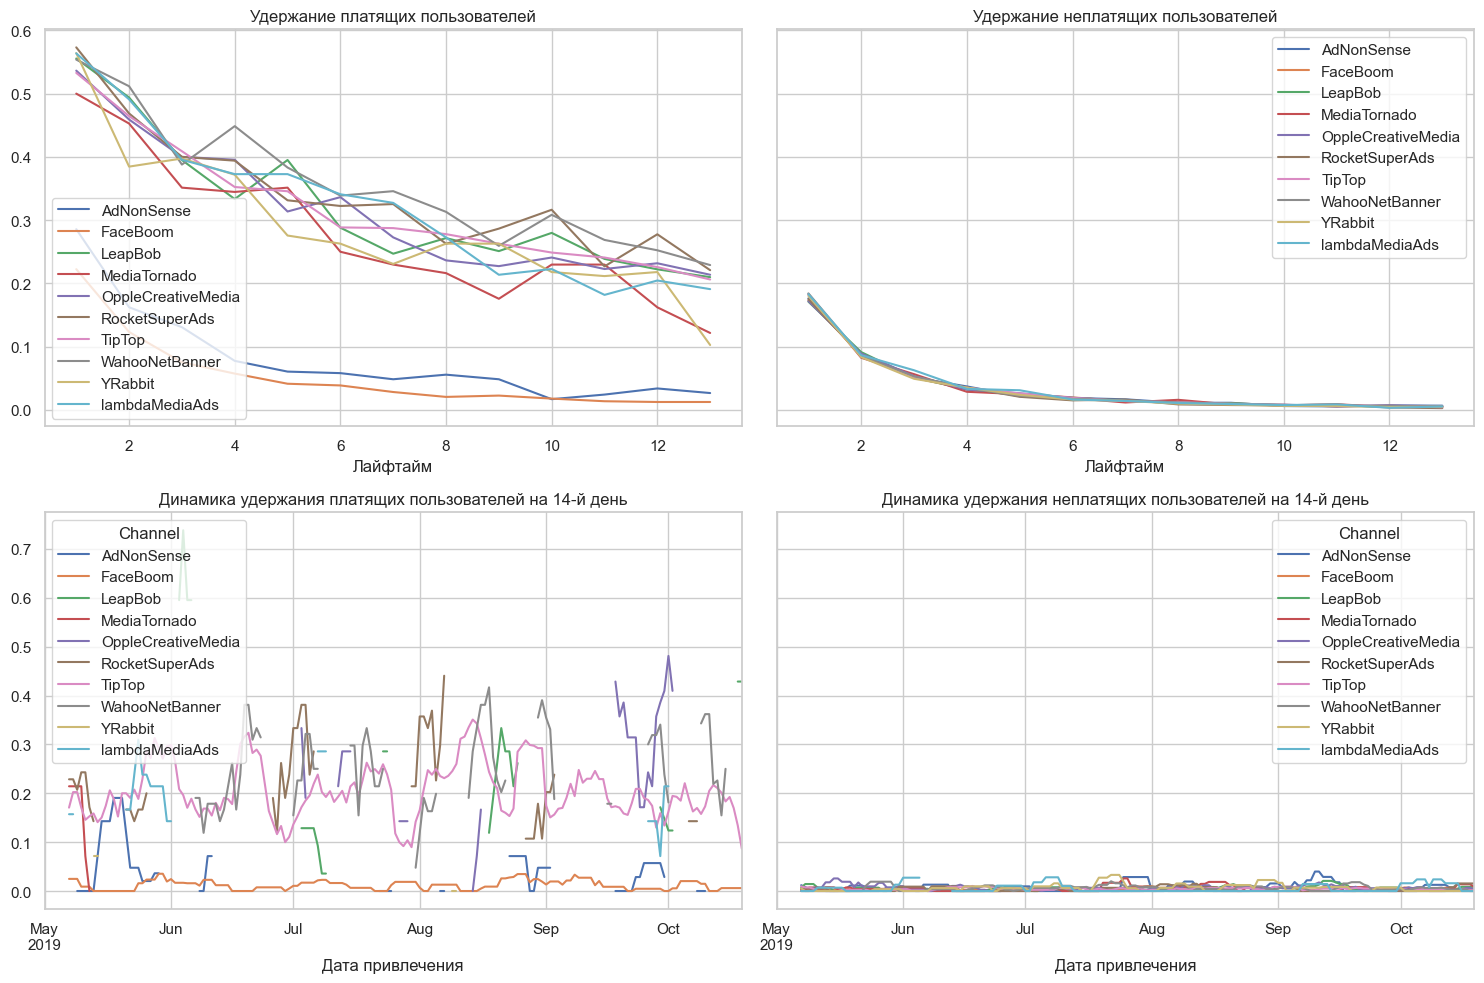

In [56]:
# Расчет удержания пользователей
retention_raw, retention_grouped, retention_history = get_retention(
    profiles=profiles,
    sessions=visits,
    observation_date=observation_date,
    horizon_days=horizon_days,
    dimensions = dimensions
)

# Построение графиков удержания и динамики его изменения
plot_retention(retention=retention_grouped, retention_history=retention_history, horizon=horizon_days)

- Пользователи с проблемных каналов  AdNonSense и FaceBoom показывают хорошую конверсию, большую, чем у остальных пользователей. Так же сравнительно неплохая конверсия у пользователей из TipTop;
- Однако удержания пользователей с каналов AdNonSense и FaceBoom значительно ниже, чем у остальных. Остальные показатели у всех пользователей примерно одинаковые.

### Выводы по разделу

Анализ показывает, что реклама в целом не окупается в первые 14 дней после привлечения пользователей. Основные проблемы связаны с высоким CAC (стоимостью привлечения) для пользователей устройств iPhone и Mac, а также для пользователей из США, что снижает ROI до уровня ниже окупаемости. Рекламные каналы, такие как TipTop, AdNonSense и FaceBoom также демонстрируют низкий ROI, несмотря на высокий LTV, что делает их менее рентабельными.

Основные проблемы - слишком большой CAC для пользователей США, пользователей iPhone и Mac, а так же пользователей с канала TipTop. С каналами AdNonSense и FaceBoom проблема с удержанием пользователей.

Можно порекомендовать оптимизацию затрат на привлечение, особенно для устройств с высоким CAC, и перераспределение бюджета на более рентабельные каналы и регионы. Возможно, от TipTop совсем стоит отказаться в пользу более рентабельных каналов или удержания органических пользователей и увеличения их конверсии, а так же пользователей с AdNonSense и FaceBoom. Также необходимо стабилизировать LTV и ROI за счет улучшения удержания пользователей и пересмотра стратегий в менее эффективных рекламных каналах.

## Оценка окупаемости рекламы США

Изучим отдельно окупаемость рекламы США, поскольку в этом регионе болше всего пользователей, а так же наибольший САС.

In [57]:
# Оставляем пользователей из США
profiles = profiles[profiles['Region'] == 'United States']

### Окупаемость рекламы в США

Проанализируем окупаемость рекламы в США c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.

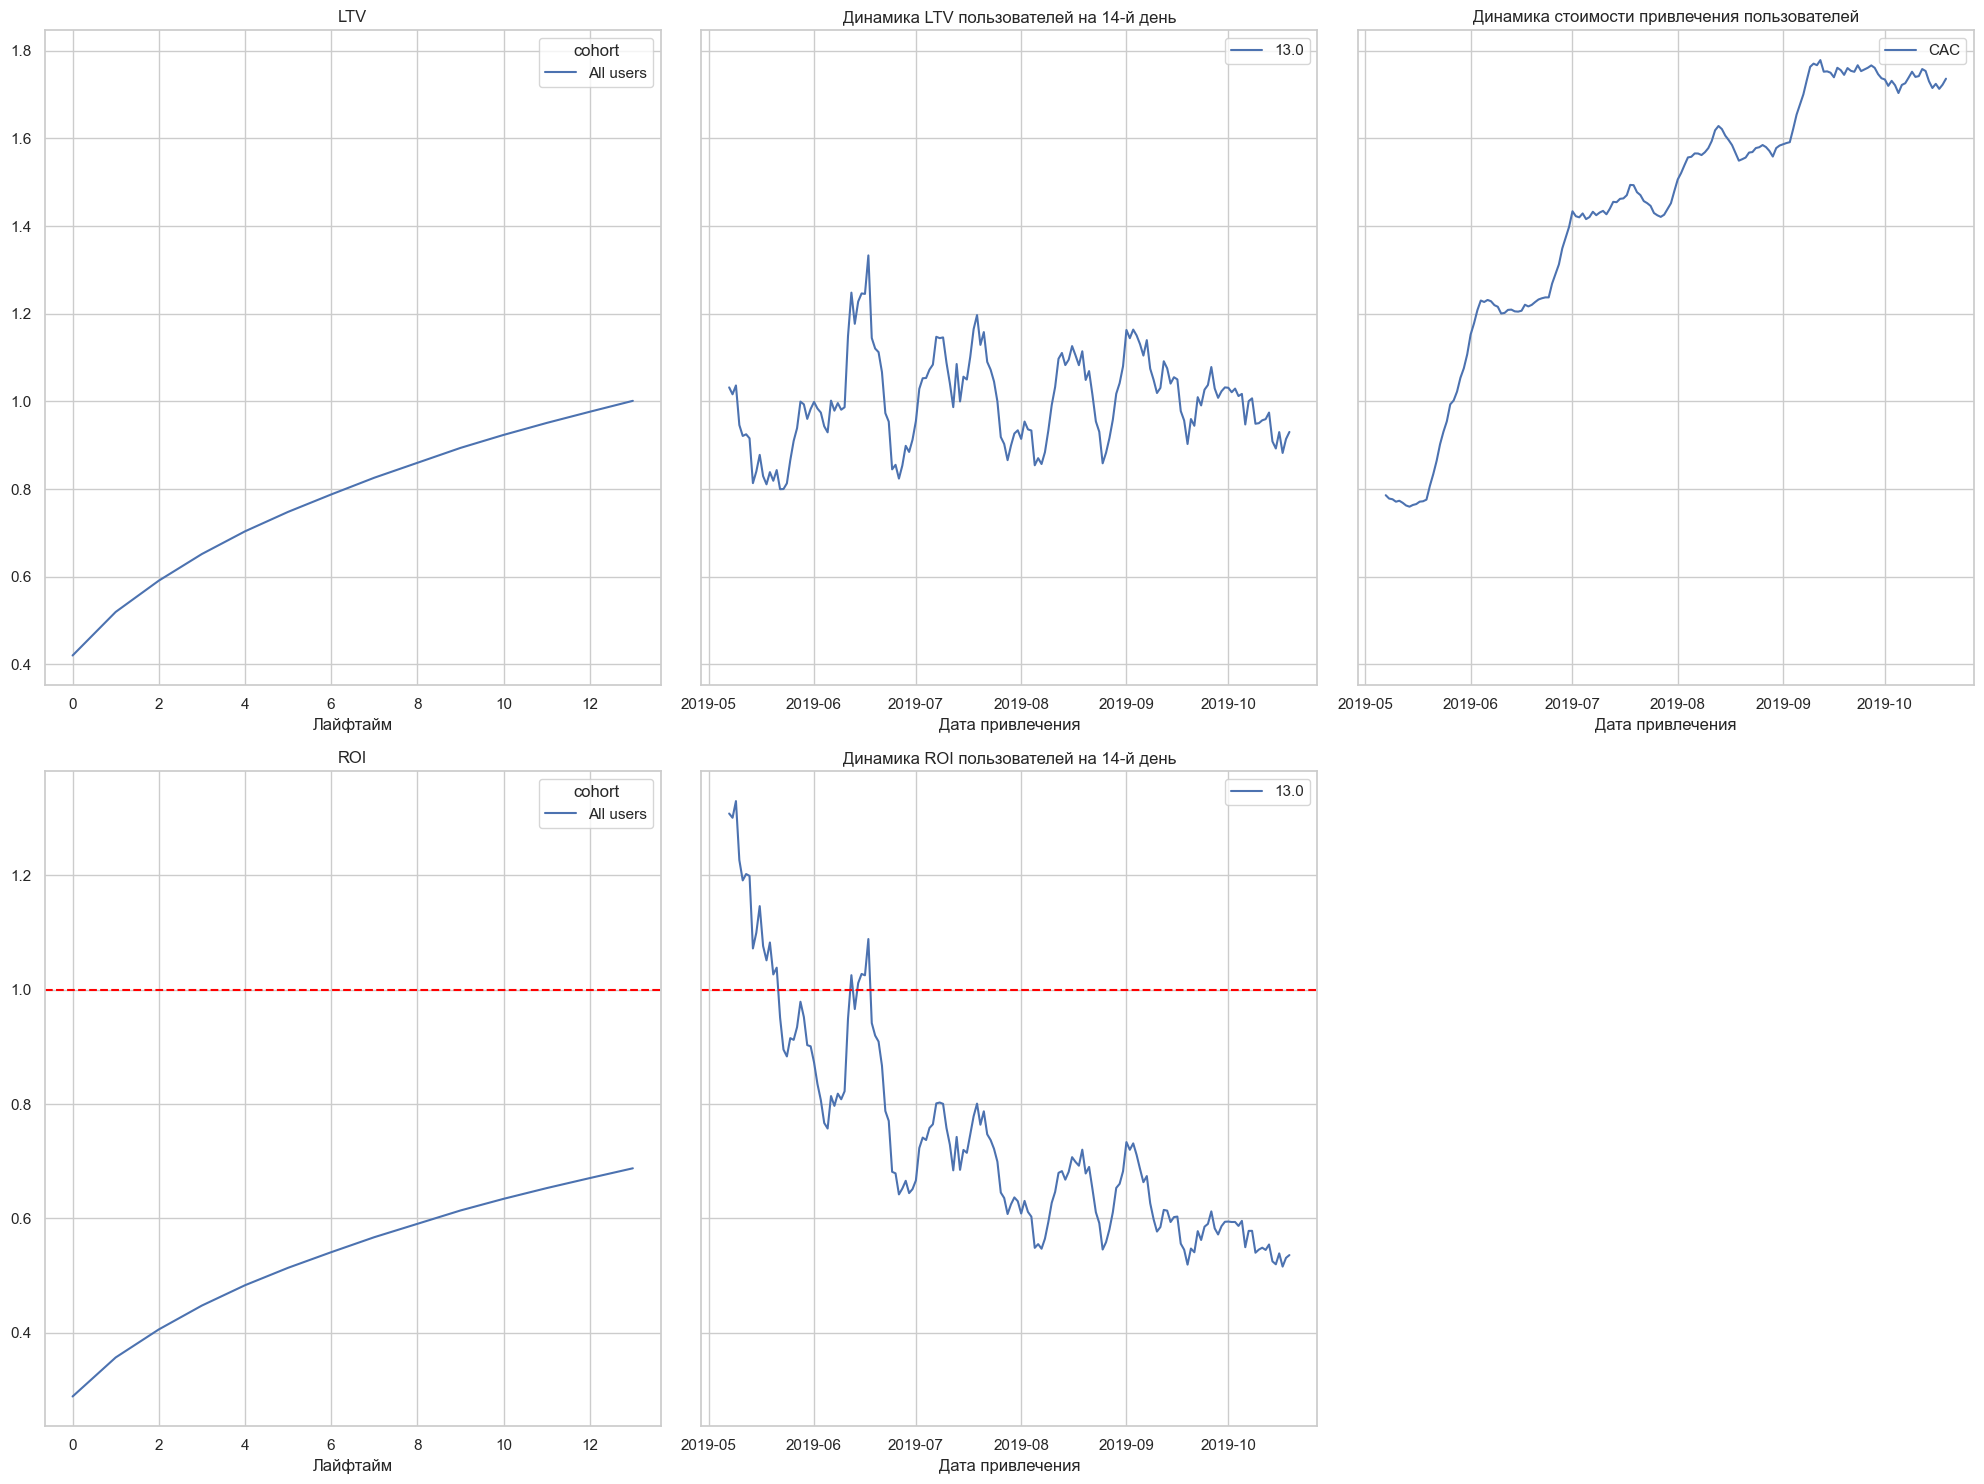

In [58]:
# Расчет LTV и ROI для пользователей, привлеченных до 1 ноября 2019 года
ltv_data, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles=profiles,
    purchases=orders,
    observation_date=observation_date,
    horizon_days=horizon_days
)

# Построение графиков для LTV, CAC, ROI
plot_ltv_roi(ltv=ltv_grouped, ltv_history=ltv_history, roi=roi_grouped, roi_history=roi_history, horizon=horizon_days)

Как мы уже и говорили, у пользователей из США хоть и имеется стабильный рост LTV, показатели CAC растут слишком сильно, что приводит к тому, что ROI не достигает уровня окупаемости за весь период.

### Конверсия пользователей США

Проверим конверсию пользователей США и динамику её изменения. То же самое сделаем с удержанием пользователей.
Построим и изучим графики конверсии и удержания.

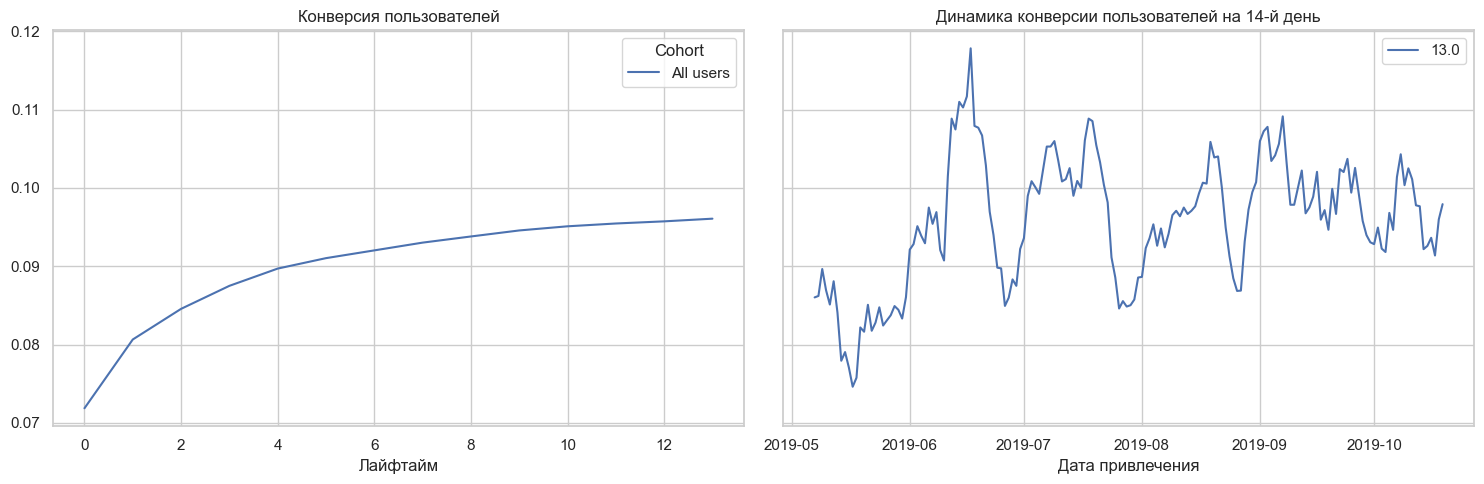

In [59]:
# Расчет конверсии пользователей
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles=profiles,
    purchases=orders,
    observation_date=observation_date,
    horizon_days=horizon_days
)

# Построение графиков конверсии и динамики ее изменения
plot_conversion(conversion=conversion_grouped, conversion_history=conversion_history, horizon=horizon_days)

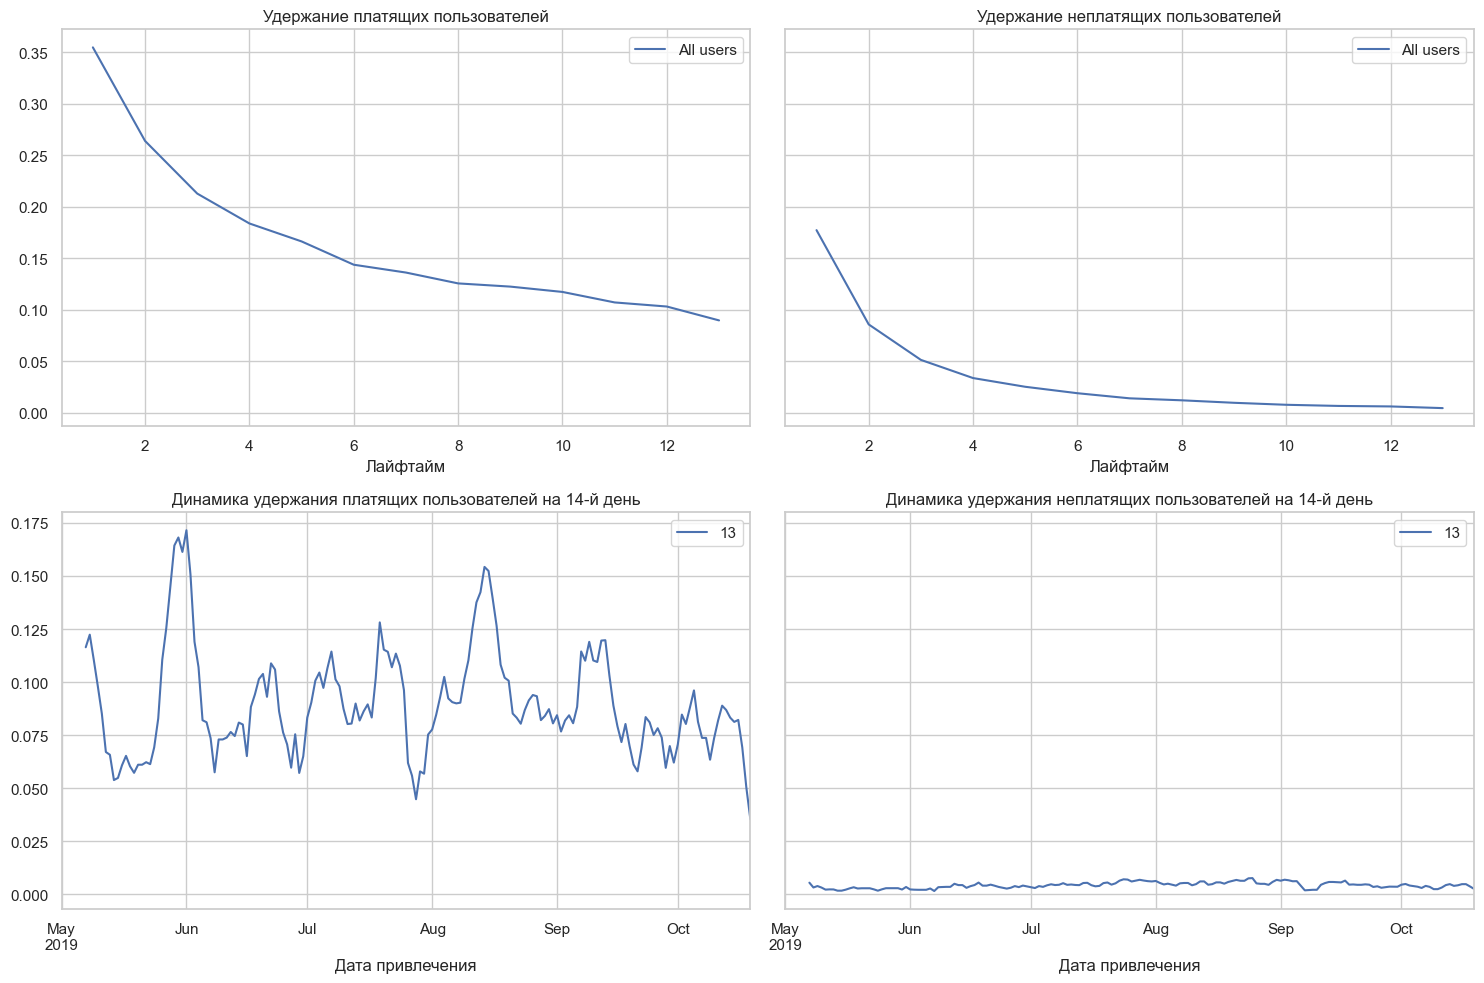

In [60]:
# Расчет удержания пользователей
retention_raw, retention_grouped, retention_history = get_retention(
    profiles=profiles,
    sessions=visits,
    observation_date=observation_date,
    horizon_days=horizon_days
)

# Построение графиков удержания и динамики его изменения
plot_retention(retention=retention_grouped, retention_history=retention_history, horizon=horizon_days)

Эту картинку мы тоже уже видели ранее, конверсия была выше остальных стран, а удержание наоборот ниже.<br>
Попробуем сделать разбивки по устройствам и рекламным каналам.

### Окупаемость рекламы в США с разбивкой по устройствам

Проанализируем окупаемость рекламы с разбивкой по устройствам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

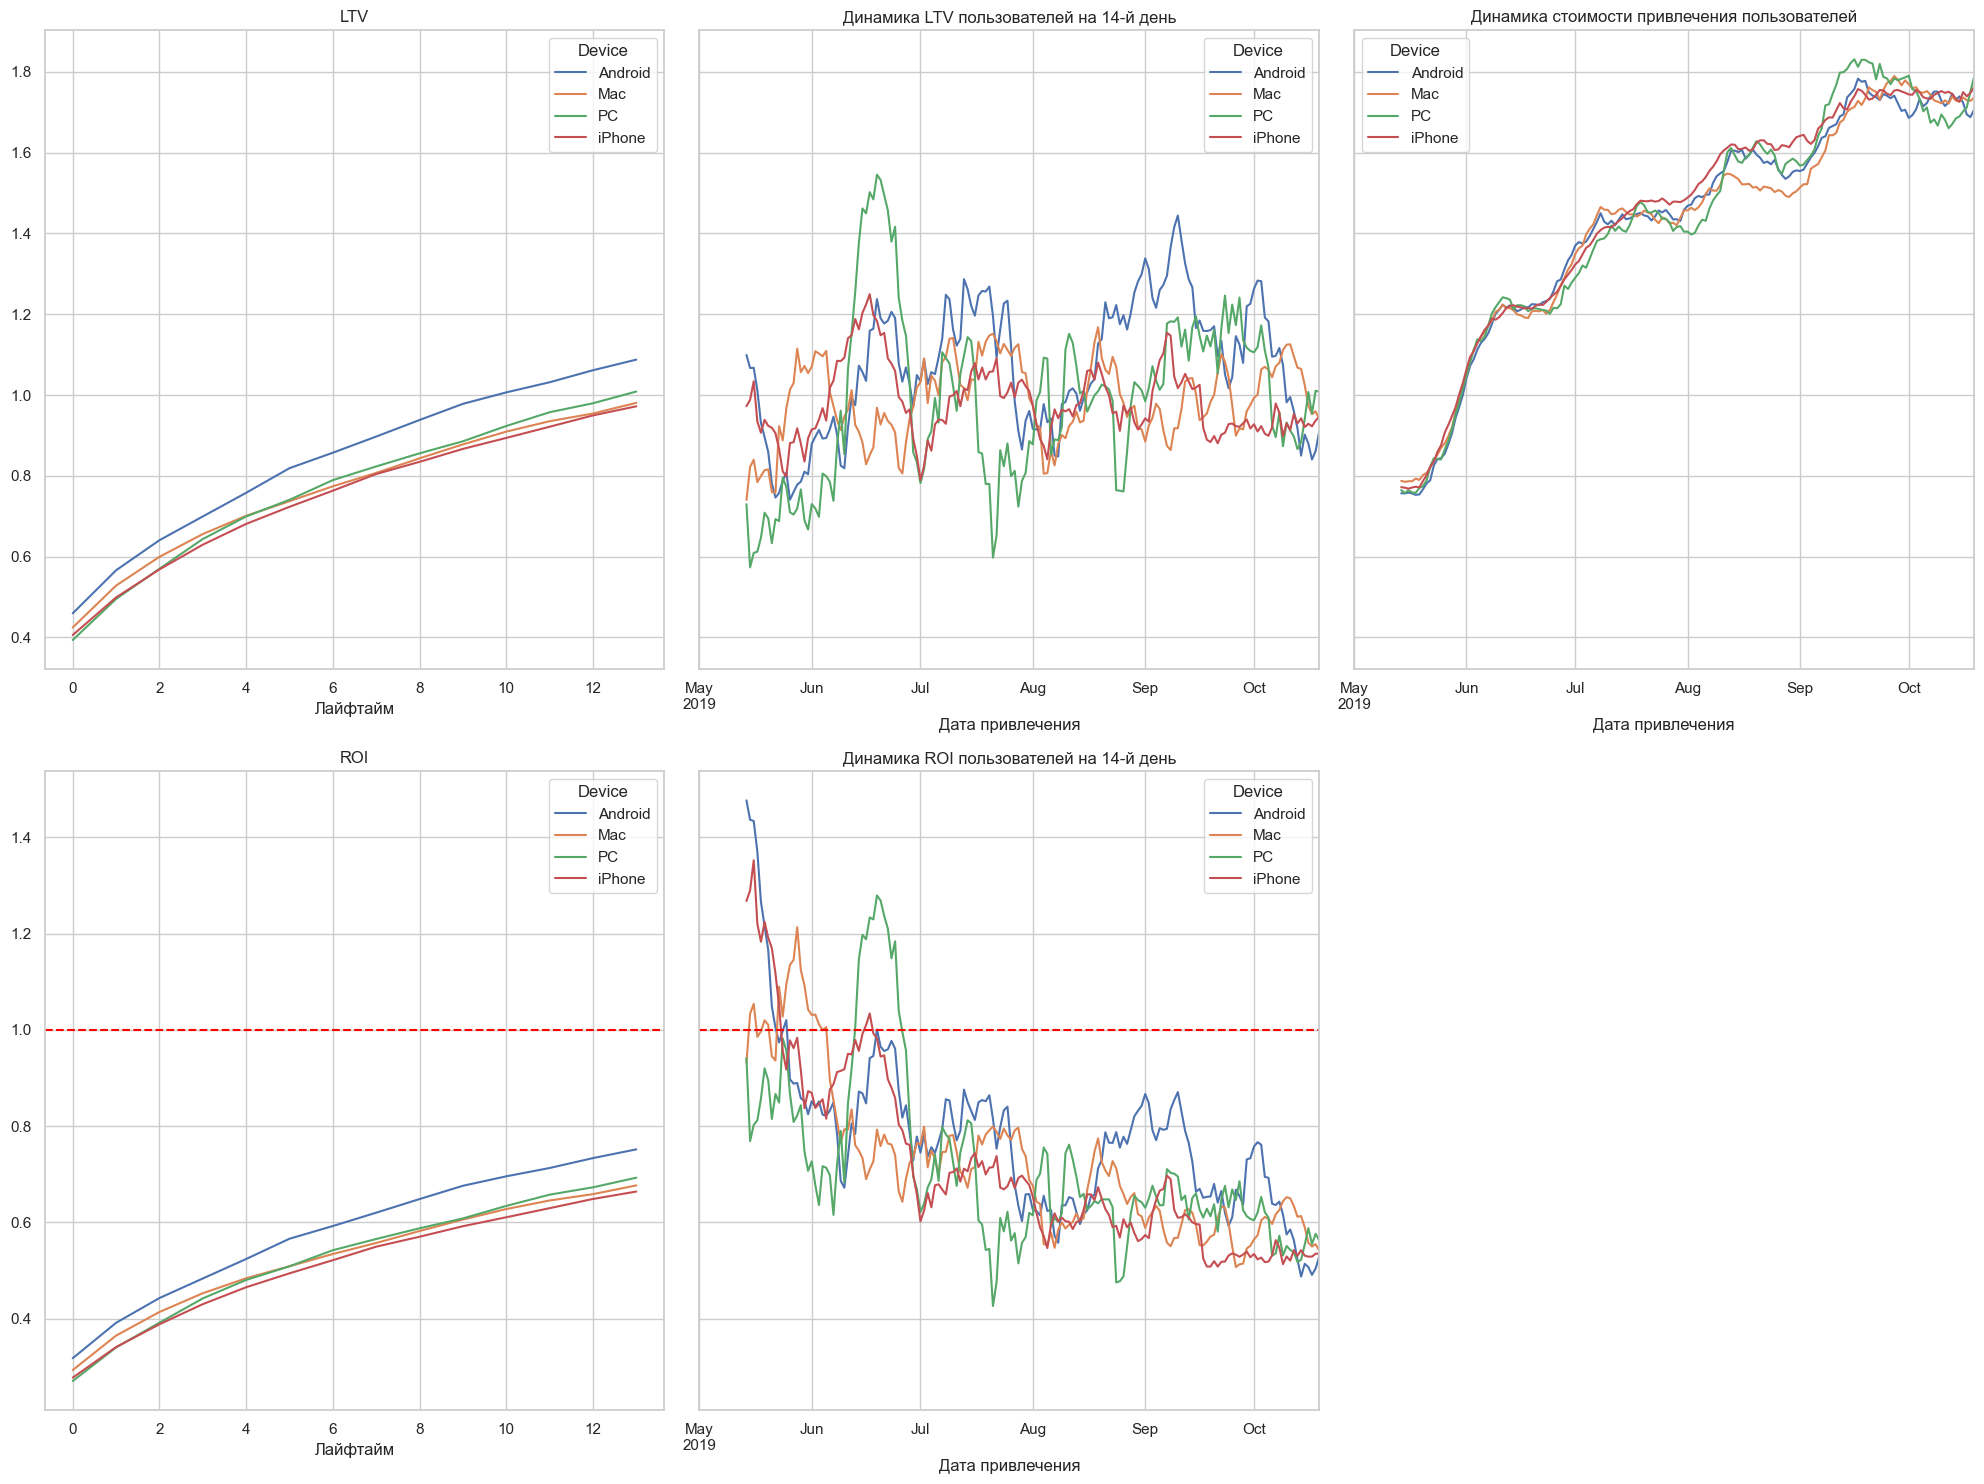

In [61]:
# Устанавливаем параметры разбиения по устройствам
dimensions = ['Device']

ltv_data, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles=profiles,
    purchases=orders,
    observation_date=observation_date,
    horizon_days=horizon_days,
    dimensions=dimensions
)

# Построение графиков LTV и ROI с разбиением по устройствам
plot_ltv_roi(ltv=ltv_grouped, ltv_history=ltv_history, roi=roi_grouped, roi_history=roi_history, horizon=horizon_days, window=14)

Ситуация похожа у всех пользователей. LTV хоть и показывает рост на протяжении всего периода, CAC слишком сильно растет, от чего ROI всех пользователей ниже уровня окупаемости.

### Конверсия пользователей США с разбивкой по устройствам

Проверим конверсию пользователей США с разбивкой по устройствам и динамику её изменения. То же самое сделаем с удержанием пользователей. Построим и изучим графики конверсии и удержания.

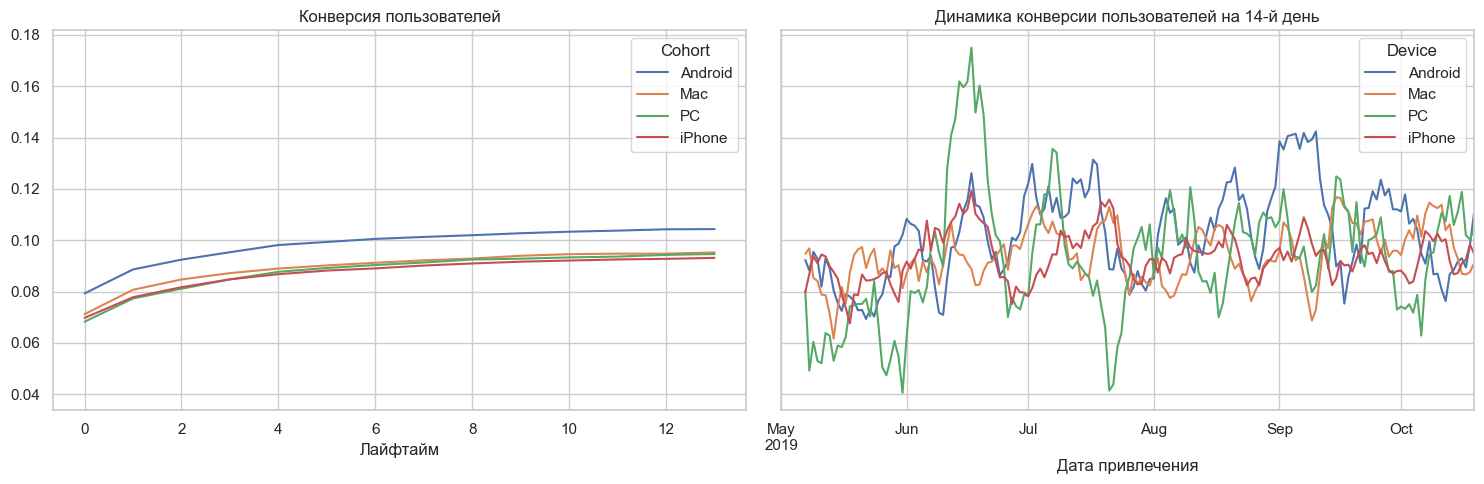

In [62]:
# Устанавливаем параметры разбиения по устройствам
dimensions = ['Device']

# Расчет конверсии пользователей
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles=profiles,
    purchases=orders,
    observation_date=observation_date,
    horizon_days=horizon_days,
    dimensions = dimensions
)

# Построение графиков конверсии и динамики ее изменения
plot_conversion(conversion=conversion_grouped, conversion_history=conversion_history, horizon=horizon_days)

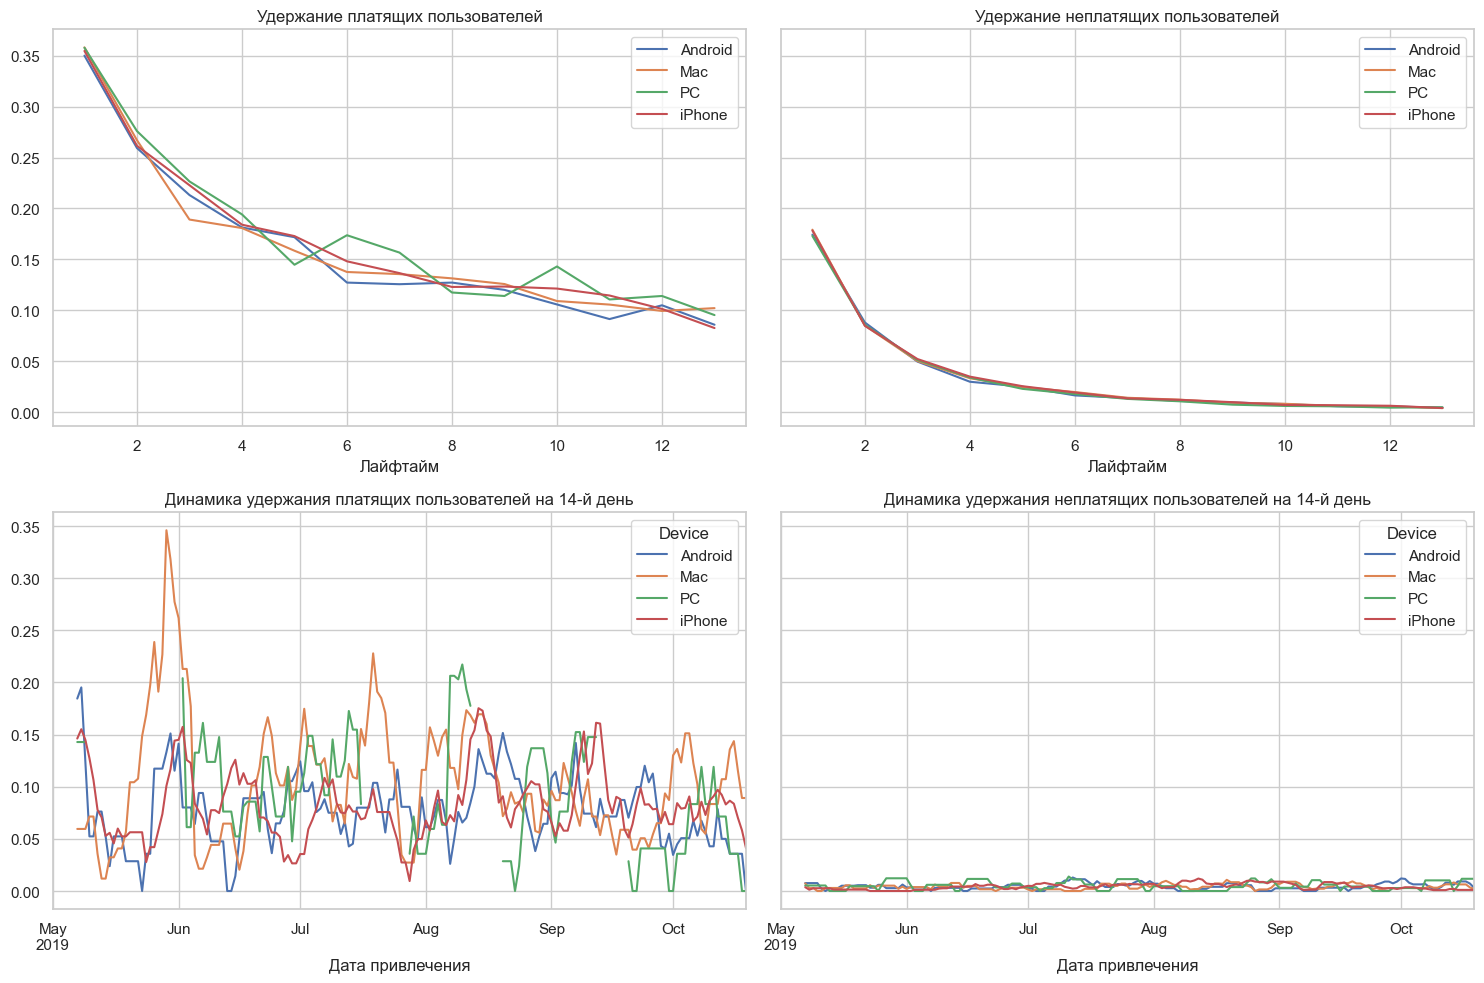

In [63]:
# Расчет удержания пользователей
retention_raw, retention_grouped, retention_history = get_retention(
    profiles=profiles,
    sessions=visits,
    observation_date=observation_date,
    horizon_days=horizon_days,
    dimensions = dimensions
)

# Построение графиков удержания и динамики его изменения
plot_retention(retention=retention_grouped, retention_history=retention_history, horizon=horizon_days)

Конверсия у пользователей Android немного выше других, но в целом все показатели примерно одинаковы у всех пользователей. 

###  Окупаемость рекламы США с разбивкой по рекламным каналам

Проанализируем окупаемость рекламы США с разбивкой по рекламным каналам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

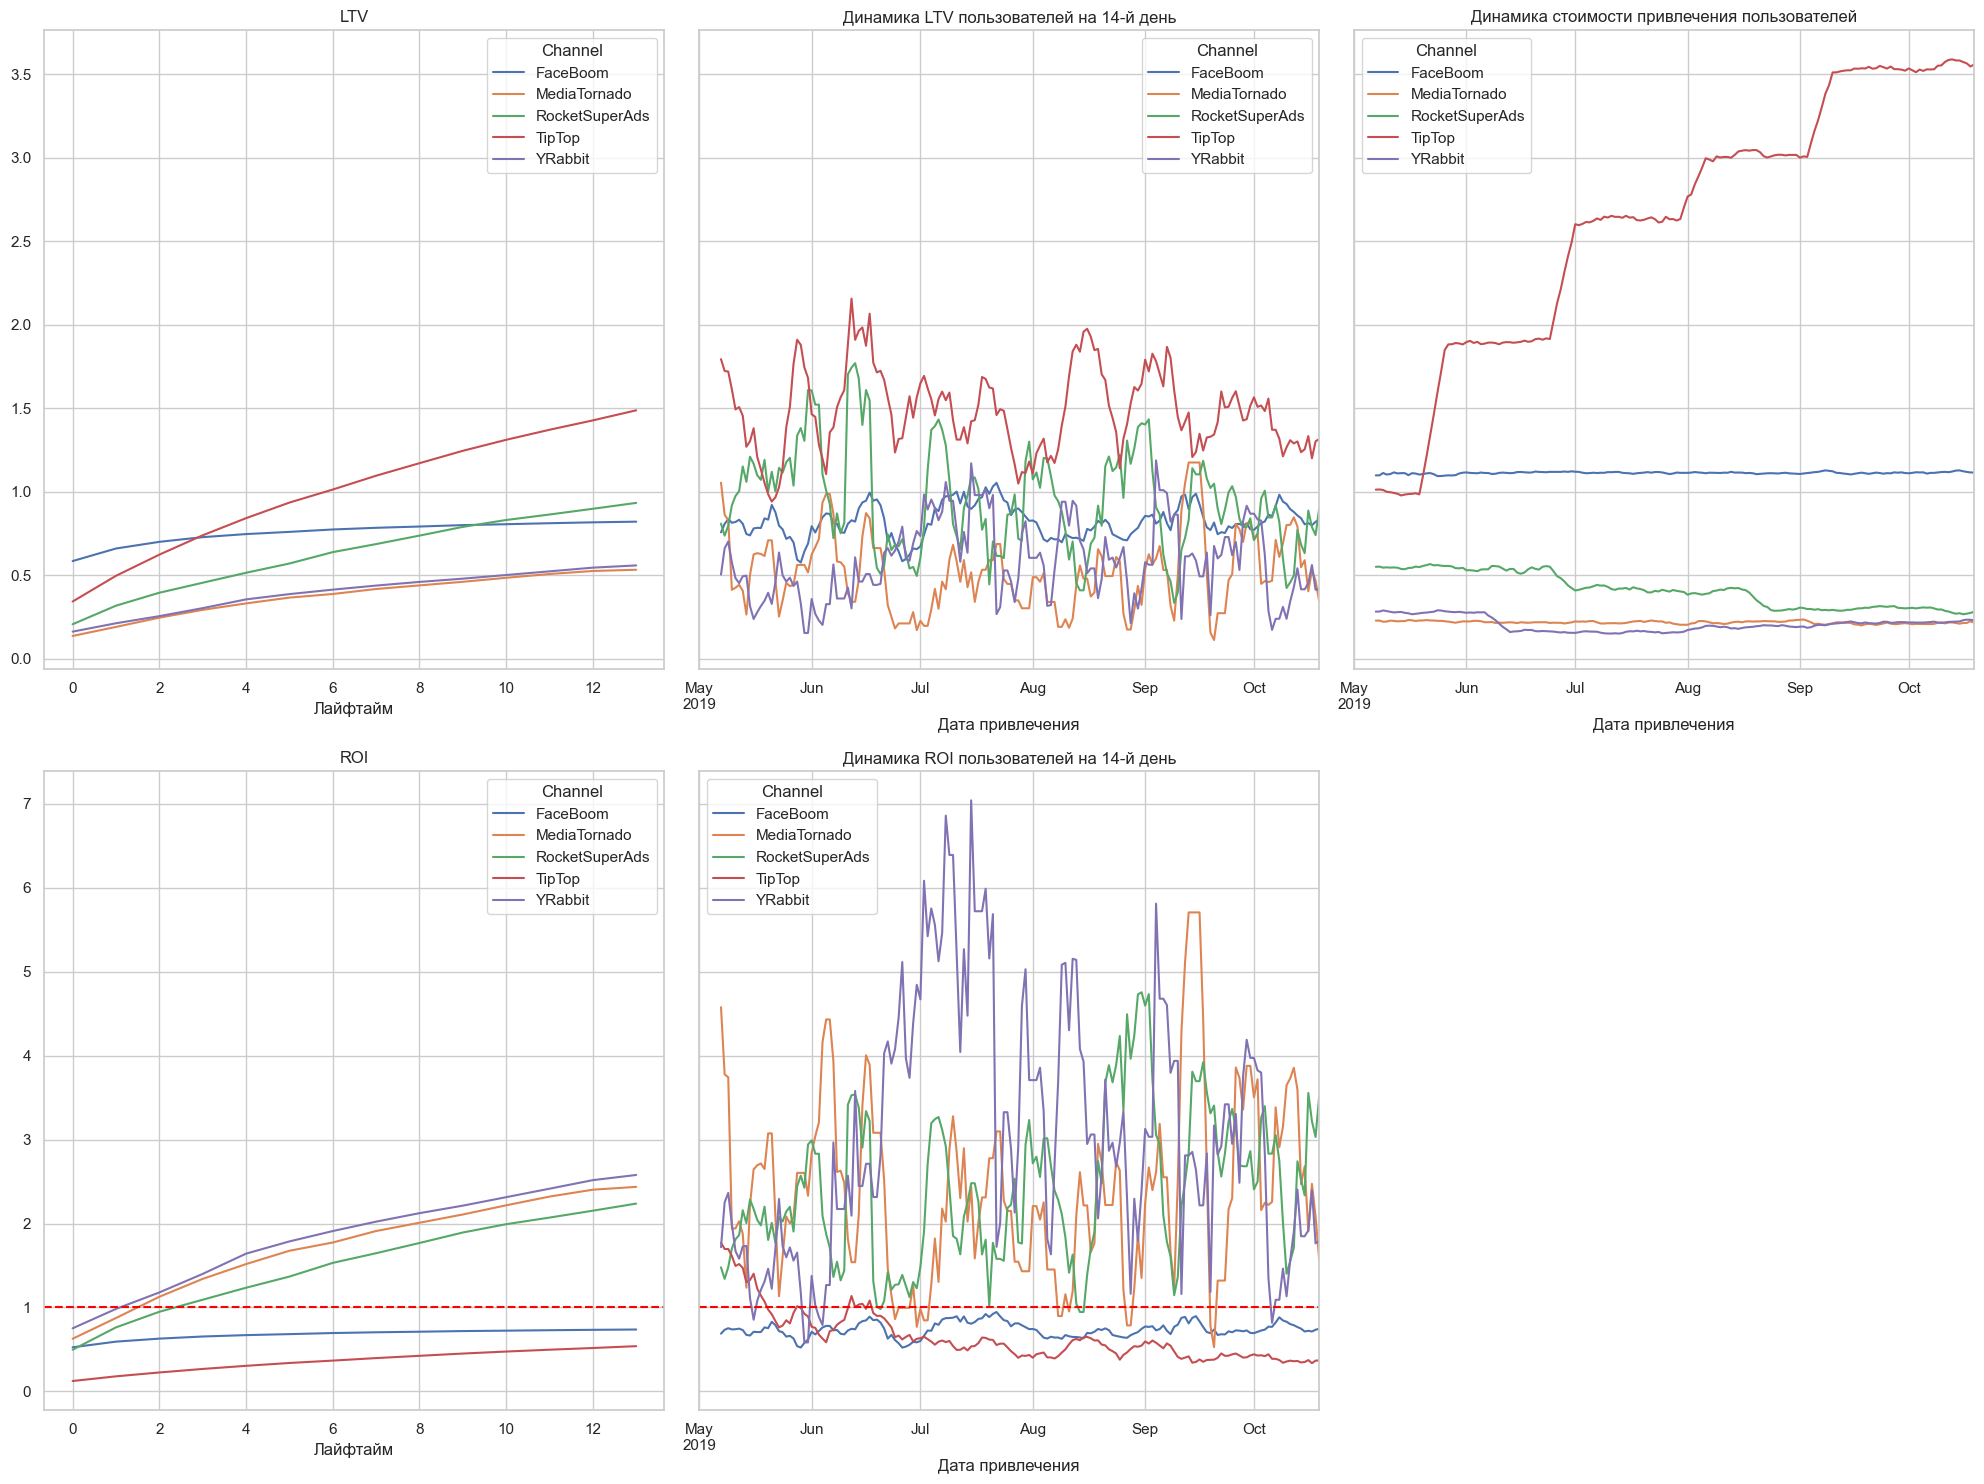

In [64]:
# Устанавливаем параметры разбиения по каналам
dimensions = ['Channel']

# Расчет LTV и ROI для пользователей с разбивкой по каналам
ltv_data, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles=profiles,
    purchases=orders,
    observation_date=observation_date,
    horizon_days=horizon_days,
    dimensions=dimensions
)

# Построение графиков LTV и ROI с разбиением по каналам
plot_ltv_roi(ltv=ltv_grouped, ltv_history=ltv_history, roi=roi_grouped, roi_history=roi_history, horizon=horizon_days)

Видим знакомые нам каналы TipTop и FaceBoom, которые портят нам картину. Как мы уже говорили, CAC у TipTop слишком большой, что делает ROI наименьшим среди всех. CAC FaceBoom хоть и стабилен, LTV остается тоже практически неизменным за весь период, от чего ROI тоже ниже отметки окупаемости весь анализируемый период, нужно посмотреть конверсию и удержание.

### Конверсия пользователей США с разбивкой по рекламным каналам

Проверим конверсию пользователей с разбивкой по рекламным каналам и динамику её изменения. То же самое сделаем с удержанием пользователей. Построим и изучим графики конверсии и удержания.

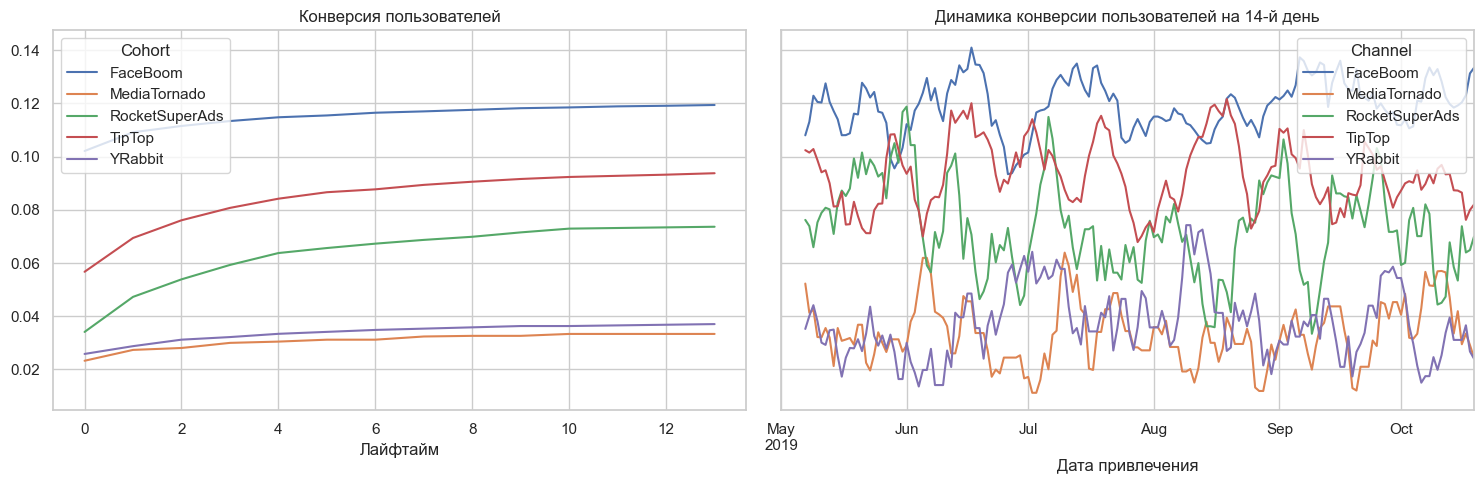

In [65]:
# Устанавливаем параметры разбиения по устройствам
dimensions = ['Channel']

# Расчет конверсии пользователей
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles=profiles,
    purchases=orders,
    observation_date=observation_date,
    horizon_days=horizon_days,
    dimensions = dimensions
)

# Построение графиков конверсии и динамики ее изменения
plot_conversion(conversion=conversion_grouped, conversion_history=conversion_history, horizon=horizon_days)

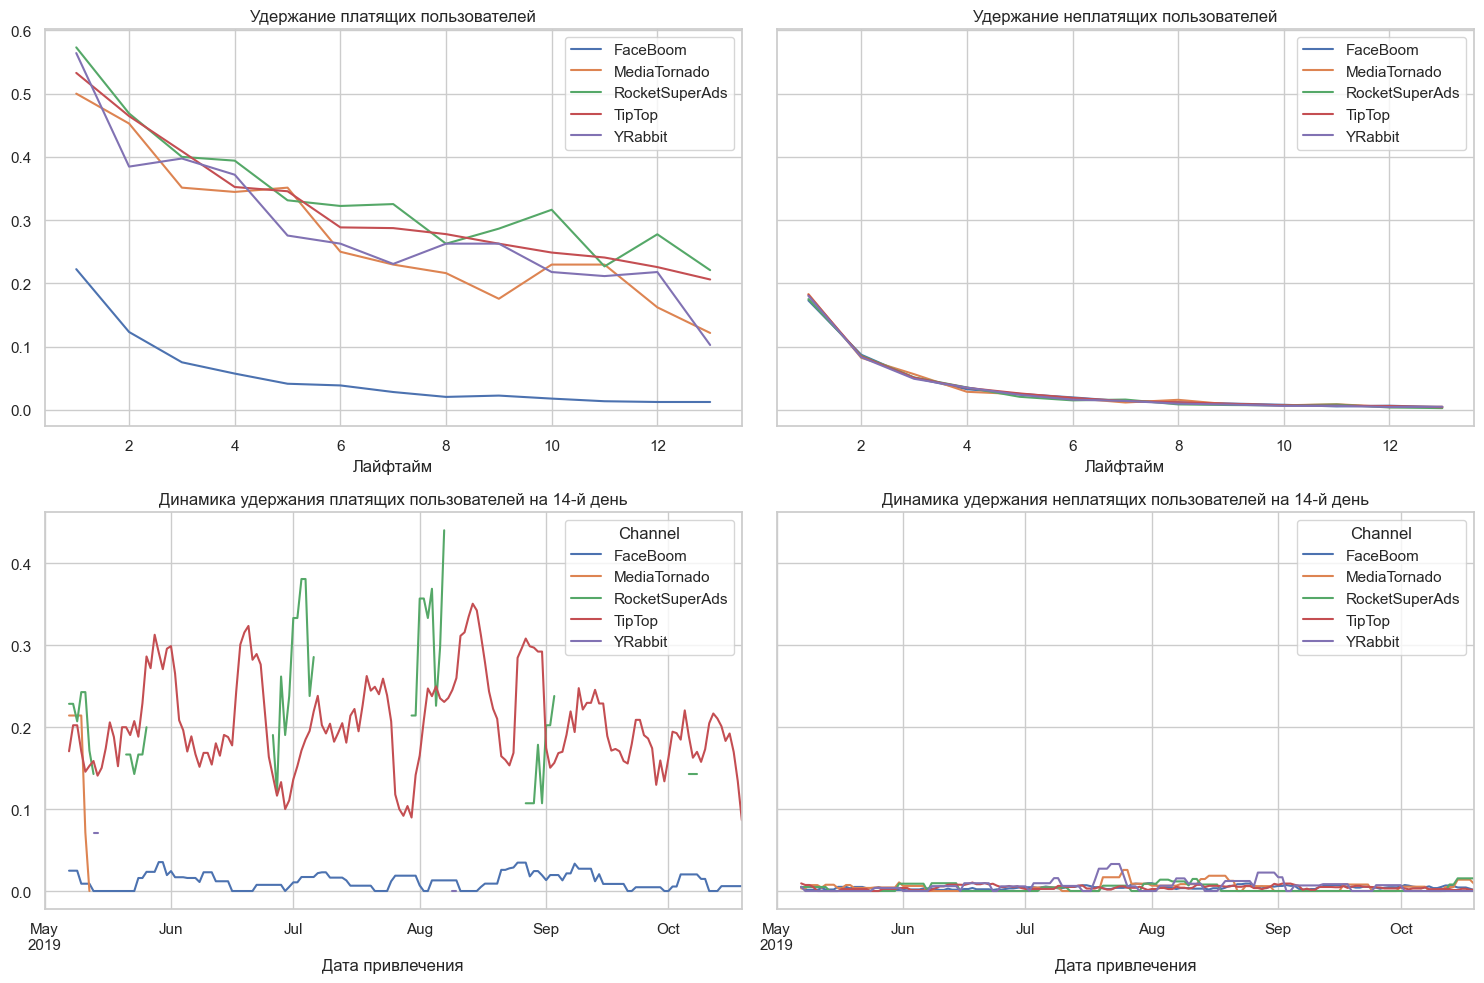

In [66]:
# Расчет удержания пользователей
retention_raw, retention_grouped, retention_history = get_retention(
    profiles=profiles,
    sessions=visits,
    observation_date=observation_date,
    horizon_days=horizon_days,
    dimensions = dimensions
)

# Построение графиков удержания и динамики его изменения
plot_retention(retention=retention_grouped, retention_history=retention_history, horizon=horizon_days)

Наблюдения снова подтвердились. Несмотря на конверсию пользователей, удержание платящих пользователей c FaceBoom значительно ниже остальных, пользователи становятся покупателями и практически перестают пользоваться приложением на второй день.  

Таким образом, основные проблемы окупаемости рекламы в США:
- общий рост CAC и слабое удержание пользователей в приложении;
- значительный рост CAC у пользователей с TipTop;
- удержание платящих пользователей с FaceBoom.

## Выводы

Анализ показал, что несмотря на значительные вложения в маркетинг, рекламные кампании в целом не обеспечивают окупаемость в первые 14 дней после привлечения пользователей. Основные причины неэффективности связаны с высоким уровнем затрат на привлечение (CAC), особенно для пользователей устройств iPhone и Mac, а также для пользователей из США. Эти группы пользователей имеют самый высокий CAC, что значительно снижает общий ROI. Кроме того, некоторые рекламные каналы, такие как TipTop, FaceBoom и AdNonSense, демонстрируют низкий ROI, несмотря на высокий LTV, что указывает на необходимость пересмотра стратегий их использования, а так же стратегии удержания платящих полльзователей. Ещё одна причина, по которой компания не выходит в плюс - низкая конверсия у органических пользователей, всего 2%.

Рекомендации для отдела маркетинга:
- Пересмотреть маркетинговые бюджеты для устройств с высоким CAC (iPhone и Mac) и стран с высокой стоимостью привлечения (США). Рассмотреть перераспределение бюджетов на более рентабельные каналы и регионы, такие как Германия, Франция и Англия, а возмжно и новые регионы;
- Проанализировать и оптимизировать стратегии для каналов с высоким CAC (TipTop), либо рассмотреть возможность их замены более эффективными;
- Проанализировать и оптимизировать стратегии для каналов с низким удержанием (FaceBoom и AdNonSense), либо рассмотреть возможность их замены более эффективными;
- Каналы к которым стоит присмотреться - lambdaMediaAds, YRabbit и RocketSuperAds;
- Учитывая низкий ROI в первые 14 дней, рекомендуется рассмотреть стратегии, направленные на увеличение долгосрочной ценности пользователя (LTV), даже если это потребует более длительного периода окупаемости;
- Проанализировать и оптимизировать стратегии для увеличения конверсии среди органических пользователей. Учитывая, что органические пользователи составляют самую большую группу, улучшение их конверсии может значительно повлиять на общий доход компании и повысить эффективность маркетинговых усилий.